 <span style="color:#42a5f5; font-size:2em; font-weight:bold;">Time series sur les données d'incidents</span>

L'objectif étant de prédire les interventions futurs des pompiers dans les années à venir afin de mieux organiser leur equipes, leurs materiel, et leur temps d'interventions ...

<span style="color:#e91e63; font-size:1em; font-weight:bold;">1. Import des bibliothèques necessaires</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

<span style="color:#e91e63; font-size:1em; font-weight:bold;">2-Chargement des données et vérifications </span>

In [2]:
# Chargement
processed_file_path = r"..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv"
if not os.path.exists(processed_file_path):
    raise FileNotFoundError(f"Le fichier {processed_file_path} n'existe pas. Veuillez vérifier le chemin.")

print(f"Chargement du fichier : {processed_file_path}")

# Colonnes utiles pour la time series
cols_to_keep = [
    "IncidentNumber", "DateOfCall", "TimeOfCall", "HourOfCall", "IncidentGroup", "IncGeo_BoroughName",
    "NumCalls", "NotionalCost", "PumpCount",
    "NumPumpsAttending", "NumStationsWithPumpsAttending"
]

# Typage strict uniquement sur les colonnes conservées
dtype_map = {
    "IncidentNumber": "string",
    "TimeOfCall": "string",
    "HourOfCall": "Int64",
    "IncidentGroup": "string",
    "IncGeo_BoroughName": "string",
    "NumCalls": "Int64",
    "NotionalCost": "Int64",
    "PumpCount": "Int64",
    "NumPumpsAttending": "Int64",
    "NumStationsWithPumpsAttending": "Int64",
}

Chargement du fichier : ..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv


<span style="color:#e91e63; font-size:1em; font-weight:bold;">3-Analyse et vérification des colonnes à mettre en Index date temps </span>

In [3]:
print(" ~~ Début de la Modélisation des Séries Temporelles ~~ ")

# Chargement avec conversion explicite
df = pd.read_csv(processed_file_path, usecols=cols_to_keep, dtype=dtype_map, parse_dates=["DateOfCall"], dayfirst=True)
df = df[df["DateOfCall"].notna()] 

print("-Type de la colonne DateOfCall :", df['DateOfCall'].dtype)
print("-Aperçu des valeurs de DateOfCall :")
display(df['DateOfCall'].drop_duplicates().head(5))

print("\n-Aperçu des 5 premières lignes du DataFrame :")
display(df.head(5))
print("types de données dans le DataFrame :")
print(df.dtypes)

# vérification des valeurs manquantes
print("-Valeurs manquantes par colonne :")
print(df.isnull().sum())

print("\n-Statistiques descriptives :")
display(df.describe(include='all'))

print("-Période de la série temporelle :")   
print(f"De: {df['DateOfCall'].min()} au: {df['DateOfCall'].max()}")

 ~~ Début de la Modélisation des Séries Temporelles ~~ 
-Type de la colonne DateOfCall : object
-Aperçu des valeurs de DateOfCall :


0       2009-01-01
405     2009-01-02
709     2009-01-03
1093    2009-01-04
1524    2009-01-05
Name: DateOfCall, dtype: object


-Aperçu des 5 premières lignes du DataFrame :


,IncidentNumber,DateOfCall,TimeOfCall,HourOfCall,IncidentGroup,IncGeo_BoroughName,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,NotionalCost,NumCalls
0,235138081,2009-01-01,00:00:37,0,Special Service,WANDSWORTH,2,2,2,255,1
1,1091,2009-01-01,00:00:46,0,Special Service,LAMBETH,<NA>,<NA>,1,255,1
2,2091,2009-01-01,00:03:00,0,Fire,ENFIELD,1,1,1,255,2
3,3091,2009-01-01,00:04:27,0,Fire,HILLINGDON,1,1,1,255,2
4,5091,2009-01-01,00:05:39,0,Fire,ISLINGTON,1,2,2,255,1


types de données dans le DataFrame :
IncidentNumber                   string[python]
DateOfCall                               object
TimeOfCall                       string[python]
HourOfCall                                Int64
IncidentGroup                    string[python]
IncGeo_BoroughName               string[python]
NumStationsWithPumpsAttending             Int64
NumPumpsAttending                         Int64
PumpCount                                 Int64
NotionalCost                              Int64
NumCalls                                  Int64
dtype: object
-Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
IncidentGroup                        6
IncGeo_BoroughName                   0
NumStationsWithPumpsAttending    14622
NumPumpsAttending                14622
PumpCount                            0
NotionalCost                        

,IncidentNumber,DateOfCall,TimeOfCall,HourOfCall,IncidentGroup,IncGeo_BoroughName,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,NotionalCost,NumCalls
count,1824973,1824973,1824973,1824973.0,1824967,1824973,1810351.0,1810351.0,1824973.0,1824973.0,1823124.0
unique,1824973,5934,86394,<NA>,3,33,<NA>,<NA>,<NA>,<NA>,<NA>
top,21091,2021-07-12,18:02:06,<NA>,False Alarm,WESTMINSTER,<NA>,<NA>,<NA>,<NA>,<NA>
freq,1,1058,56,<NA>,894018,133650,<NA>,<NA>,<NA>,<NA>,<NA>
mean,NaN,NaN,NaN,13.462605,NaN,NaN,1.370929,1.555361,1.592914,407.816033,1.327807
std,NaN,NaN,NaN,6.258045,NaN,NaN,0.687726,0.845371,1.582791,2701.663304,1.487098
min,NaN,NaN,NaN,0.0,NaN,NaN,1.0,1.0,1.0,255.0,1.0
25%,NaN,NaN,NaN,9.0,NaN,NaN,1.0,1.0,1.0,290.0,1.0
50%,NaN,NaN,NaN,14.0,NaN,NaN,1.0,1.0,1.0,328.0,1.0
75%,NaN,NaN,NaN,19.0,NaN,NaN,2.0,2.0,2.0,364.0,1.0


-Période de la série temporelle :
De: 2009-01-01 au: 2025-03-31


In [5]:
#vérification des valeurs manquantes
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
IncidentGroup                        6
IncGeo_BoroughName                   0
NumStationsWithPumpsAttending    14622
NumPumpsAttending                14622
PumpCount                            0
NotionalCost                         0
NumCalls                          1849
dtype: int64


In [4]:
# Conversion 
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'], dayfirst=True, errors='coerce')

# Sélection des lignes entre 3 mars et 31 mars 2025
mask_march25 = (df['DateOfCall'] >= '2025-03-03') & (df['DateOfCall'] <= '2025-03-31')
df_march25 = df.loc[mask_march25, ['DateOfCall', 'TimeOfCall']]

# VérifiCATION s'il y a des valeurs manquantes dans TimeOfCall
missing_time = df_march25['TimeOfCall'].isna().sum()
total_rows = df_march25.shape[0]

print(f"\nSur {total_rows} lignes entre le 3 et le 31 mars 2025 :")
print(f"- {missing_time} lignes ont TimeOfCall manquant")
print(f"- {total_rows - missing_time} lignes ont un TimeOfCall valide")

# V2RIFIE SIR IL Y A Des lignes manquantes
if missing_time > 0:
    print("\nVoici un aperçu des lignes concernées (DateOfCall sans TimeOfCall) :")
    display(df_march25[df_march25['TimeOfCall'].isna()])



Sur 340 lignes entre le 3 et le 31 mars 2025 :
- 0 lignes ont TimeOfCall manquant
- 340 lignes ont un TimeOfCall valide



<span style="color:#e91e63; font-size:1em; font-weight:bold;">4-Construction de l'Indexation</span>

In [9]:
# Vérifie que TimeOfCall est bien une chaîne au format hh:mm:ss
# Si jamais TimeOfCall n'a pas les secondes, on les ajoute artificiellement
df['TimeOfCall'] = df['TimeOfCall'].apply(lambda x: x if len(x.split(':')) == 3 else x + ':00')

# Maintenant, tu peux forcer DateTime proprement
df['DateTime'] = pd.to_datetime(df['DateOfCall'].dt.strftime('%Y-%m-%d') + ' ' + df['TimeOfCall'],errors='coerce')

# Correction claire
df = df[df['DateOfCall'] < '2025-04-01']

# Mets DateTime en index
df.set_index('DateTime', inplace=True)

# Vérification
print("\nIndexation DateTime OK")
print(f"Index DateTime : de {df.index.min()} à {df.index.max()}")
print(f"DateOfCall : de {df['DateOfCall'].min()} à {df['DateOfCall'].max()}")



Indexation DateTime OK
Index DateTime : de 2009-01-01 00:00:37 à 2025-03-03 23:43:30
DateOfCall : de 2009-01-01 00:00:00 à 2025-03-03 00:00:00


In [10]:
# Vérifie si des lignes sont invalides entre le 3 et 31 mars
df_check = df[(df['DateOfCall'] >= '2025-03-01') & (df['DateOfCall'] <= '2025-03-31')].copy()

# Crée une colonne DateTime provisoire
df_check['DateTime_temp'] = pd.to_datetime(
    df_check['DateOfCall'].dt.strftime('%Y-%m-%d') + ' ' + df_check['TimeOfCall'].astype(str),
    errors='coerce'
)

# Montre les lignes posant problème
invalid = df_check[df_check['DateTime_temp'].isna()]
print(f"\nNombre de lignes mal converties entre le 3 et 31 mars : {len(invalid)}")

if not invalid.empty:
    display(invalid[['DateOfCall', 'TimeOfCall']].head(20))



Nombre de lignes mal converties entre le 3 et 31 mars : 0


<span style="color:#e91e63; font-size:1em; font-weight:bold;">5-Vérifications des appels reçus qui déclenchent les interventions  </span>

Valeurs uniques dans NumCalls :
<IntegerArray>
[   1,    2,    7,    3,   16,    6,    4,    5,   12,   17,   14,    8,   20,
   11, <NA>,   29,    9,   22,   10,   24,   15,   19,   18,   13,   31,   21,
   45,   27,   36,   37,   38,   23,   59,   26,   35,  118,   46,   28,   43,
   52,   33,   32,  130,   34,   42,   72,   30,   25,   74,   47,   39,   65,
   62,   56,   40,   66,   53,   49,   83,  111,   64,   48,   95,   44,   41,
   50,   67,   51,   73,   97,   60,   54,   80,   57,  127]
Length: 75, dtype: Int64


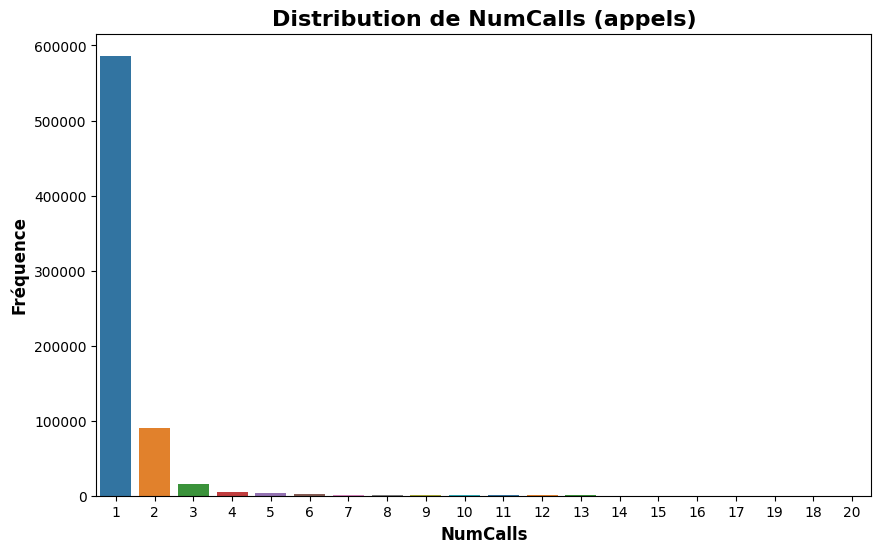

In [11]:
# Test de la colonne NumCalls pour determiner les appels pour chaque incident:
# Analyse des valeurs uniques de NumCalls
print("Valeurs uniques dans NumCalls :")
print(df["NumCalls"].unique())

# on réinitialise l’index SANS toucher au df original
num_df = df[df['NumCalls'] <= 20].reset_index(drop=True)

# ordre des barres : du plus fréquent au moins fréquent
order = num_df['NumCalls'].value_counts().index 

# Distribution de NumCalls
plt.figure(figsize=(10, 6))
sns.countplot(data=num_df, x='NumCalls', order=order, palette='tab10')
plt.title("Distribution de NumCalls (appels)", fontsize=16, fontweight='bold')
plt.xlabel("NumCalls", fontsize=12, fontweight='bold')
plt.ylabel("Fréquence", fontsize=12, fontweight='bold')
plt.show()

Environ 90–95 % (visuellement estimé) des incidents ne sont associés qu’à un seul appel !
Cela suggère que pour la plupart des situations, un seul appel suffit à déclencher l’intervention ou à gérer l’incident.

In [12]:
# 1) Lignes où NumCalls est manquant
na_calls = df[df["NumCalls"].isna()]
print(f"Nombre de lignes avec NumCalls manquant : {na_calls.shape[0]}")

# 1-a) Y a-t-il plusieurs enregistrements pour le même IncidentNumber ?
dup_incidents = na_calls.duplicated(subset="IncidentNumber").sum()
print(f"Duplications sur IncidentNumber parmi les NA : {dup_incidents}")

# 1-b) Distribution (rapide) d’autres indicateurs pour comparer aux incidents « normaux »
cols_check = ["NotionalCost", "PumpCount", "NumPumpsAttending", "IncidentGroup", "IncidentNumber", "DateOfCall"]
print("\nRésumé stats des colonnes comparatives :")
display(na_calls[cols_check].describe())

# 1-c) Profil des groupes d’incident
print("\nTop 10 des IncidentGroup pour NA :")
print(na_calls["IncidentGroup"].value_counts().head(10))


Nombre de lignes avec NumCalls manquant : 733
Duplications sur IncidentNumber parmi les NA : 0

Résumé stats des colonnes comparatives :


,NotionalCost,PumpCount,NumPumpsAttending,DateOfCall
count,733.0,733.0,716.0,733
mean,301.758527,1.564802,1.564246,2011-12-16 20:43:32.824011008
min,255.0,1.0,1.0,2009-01-02 00:00:00
25%,260.0,1.0,1.0,2010-02-05 00:00:00
50%,260.0,1.0,1.0,2011-05-03 00:00:00
75%,290.0,2.0,2.0,2013-09-03 00:00:00
max,6578.0,8.0,6.0,2024-06-07 00:00:00
std,279.662834,0.829915,0.762811,NaN



Top 10 des IncidentGroup pour NA :
IncidentGroup
False Alarm        531
Fire               134
Special Service     68
Name: count, dtype: Int64


Pas de doublons sur IncidentNumber, Chaque ligne est un incident unique car pas de doublons	
PumpCount ≥ 1 (min = 1, mean ≈ 1,6)	Au moins un engin s’est déplacé → il y a eu  donc un vrai appel !	
NotionalCost ≥ 255 £ (coût > 0 pour toutes)	Un coût est logiquement généré seulement si l’appel est valide !
IncidentGroup majoritairement “False Alarm” (71 %)	Même pour une fausse alerte, il faut au moins un appel pour déclencher l’intervention

Décision: ==>Imputation des NA en 1 

In [13]:
# Traitement des valeurs manquantes dans NumCalls
# 1. Identifier les lignes avec NumCalls manquant:
numcalls_na = df["NumCalls"].isna()

# 2. Déterminer si l'incident montre une vraie intervention (coût ou engin mobilisé):
intervention_probable = (
    (df["PumpCount"] > 0) |
    (df["NumPumpsAttending"] > 0) |
    (df["NotionalCost"] > 0)
)

# 3. Imputer 1 appel si une intervention est probable:
df.loc[numcalls_na & intervention_probable, "NumCalls"] = 1

# 4. Pour les rares cas restants, imputer 0:
df["NumCalls"].fillna(0, inplace=True)

# 5. Vérification:
print("Distribution finale des valeurs de NumCalls :")
print(df["NumCalls"].value_counts(dropna=False).sort_index())
print(df["NumCalls"].isna())
print(df['NumCalls'].isnull())
print(df['NumCalls'].describe)

Distribution finale des valeurs de NumCalls :
NumCalls
1      587098
2       90644
3       15207
4        5448
5        2998
        ...  
97          1
111         1
118         1
127         1
130         1
Name: count, Length: 74, dtype: Int64
DateTime
2009-01-01 00:00:37    False
2009-01-01 00:00:46    False
2009-01-01 00:03:00    False
2009-01-01 00:04:27    False
2009-01-01 00:05:39    False
                       ...  
2025-03-03 23:21:29    False
2025-03-03 23:27:20    False
2025-03-03 23:28:13    False
2025-03-03 23:37:40    False
2025-03-03 23:43:30    False
Name: NumCalls, Length: 709999, dtype: bool
DateTime
2009-01-01 00:00:37    False
2009-01-01 00:00:46    False
2009-01-01 00:03:00    False
2009-01-01 00:04:27    False
2009-01-01 00:05:39    False
                       ...  
2025-03-03 23:21:29    False
2025-03-03 23:27:20    False
2025-03-03 23:28:13    False
2025-03-03 23:37:40    False
2025-03-03 23:43:30    False
Name: NumCalls, Length: 709999, dtype: bool
<bound me

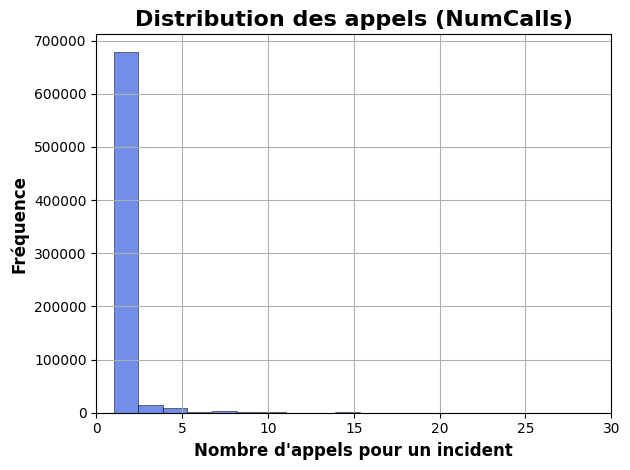

In [14]:
# Histogramme centré sur les valeurs les plus courantes
sns.histplot(df["NumCalls"], bins=90, color="royalblue")
plt.xlim(0, 30)  
plt.title("Distribution des appels (NumCalls)", fontsize=16, fontweight='bold')
plt.xlabel("Nombre d'appels pour un incident", fontsize=12, fontweight='bold')
plt.ylabel("Fréquence", fontsize=12, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

Distribution très déséquilibrée:
La quasi-totalité des incidents sont associés à très peu d'appels (typiquement entre 1 et 5)

Hourly : (141744, 15) | Daily : (5906, 15) | Weekly : (845, 15) | Monthly : (195, 15)


,weekday,hour,NumCalls_count,NumCalls_sum,NumCalls_mean,NotionalCost_count,NotionalCost_sum,NotionalCost_mean,PumpCount_count,PumpCount_sum,PumpCount_mean,NumPumpsAttending_count,NumPumpsAttending_sum,NumPumpsAttending_mean,NumStationsWithPumpsAttending_count,NumStationsWithPumpsAttending_sum,NumStationsWithPumpsAttending_mean
0,0,0,3395,4757,1.401178,3395,1363709,401.681591,3395,5432,1.6,3366,5261,1.562983,3366,4541,1.349079
1,0,1,2735,3974,1.453016,2735,1388707,507.753931,2735,4572,1.671664,2727,4274,1.56729,2727,3665,1.343968
2,0,2,2221,3201,1.441243,2221,977494,440.114363,2221,3671,1.652859,2199,3518,1.599818,2199,3026,1.37608
3,0,3,1878,2676,1.42492,1878,877292,467.14164,1878,3149,1.676784,1865,2996,1.606434,1865,2561,1.37319
4,0,4,1714,2350,1.371062,1714,763102,445.217036,1714,2802,1.634772,1673,2645,1.580992,1673,2265,1.353855


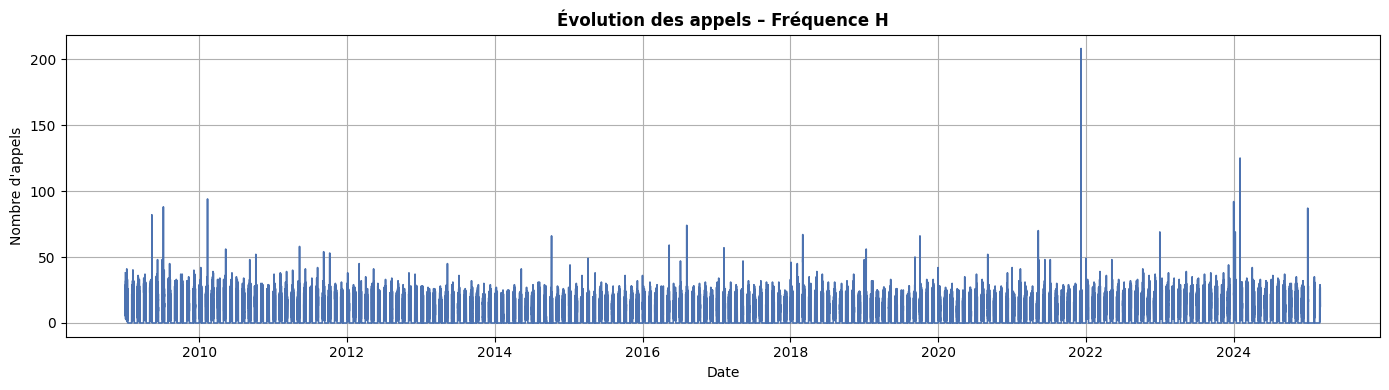

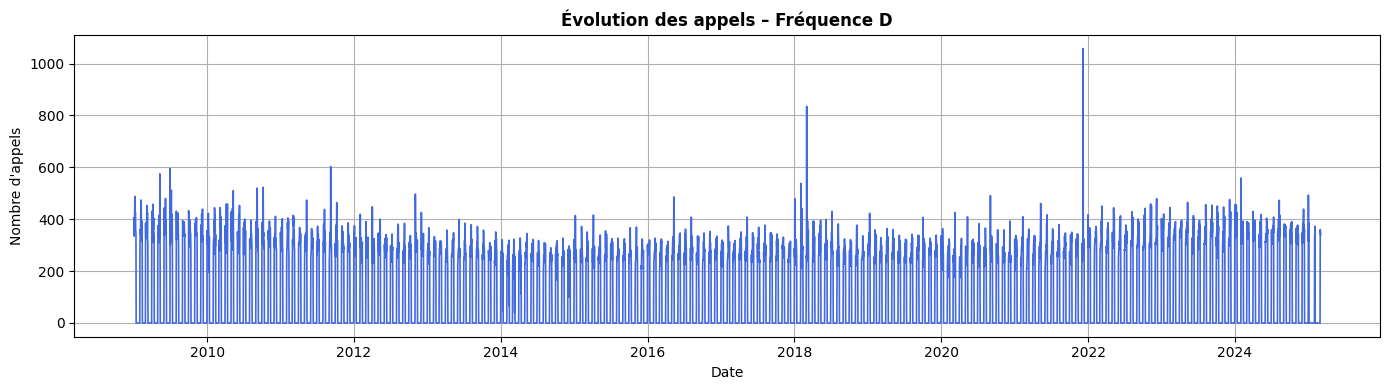

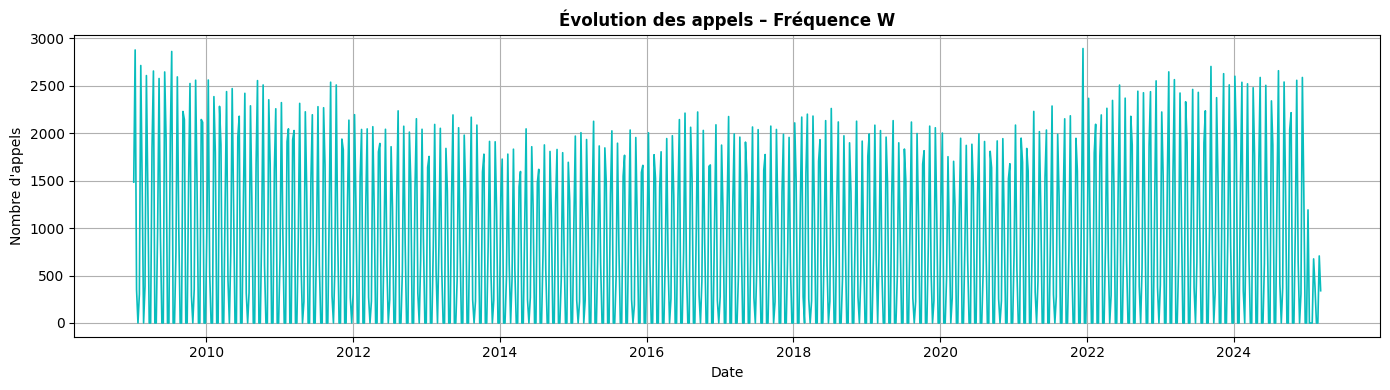

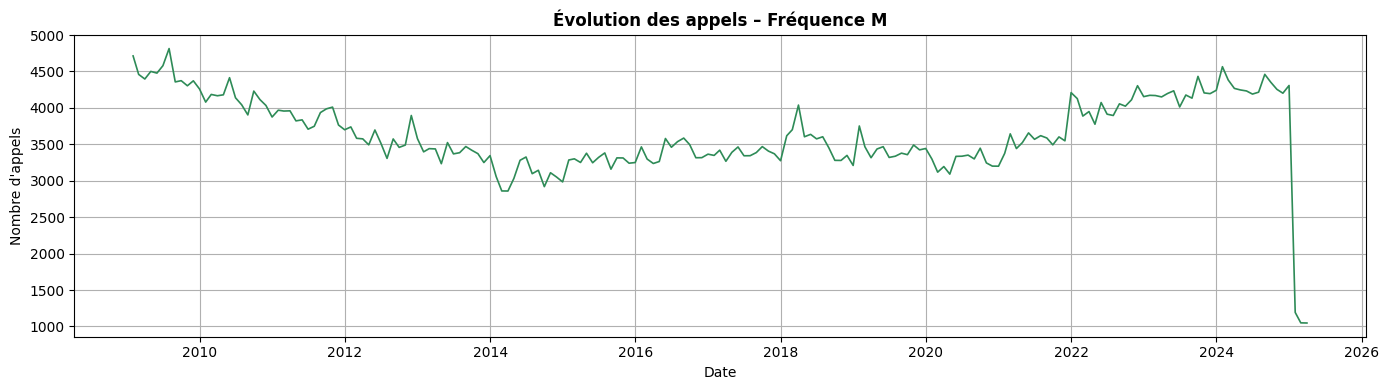

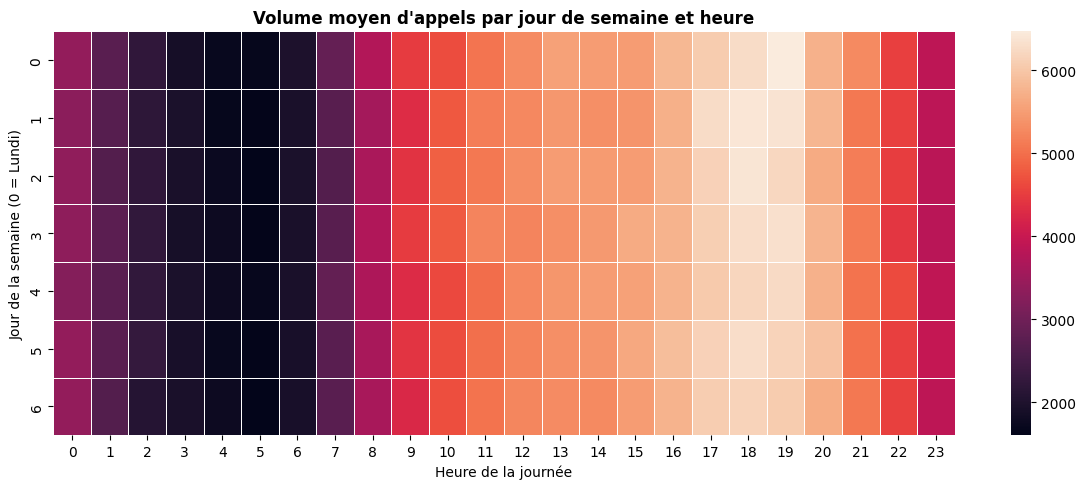

In [15]:
#Enrichissement calendaire & fonctions d'agrégation temps:
# 1-a) Ajout de colonnes temporelles explicites:
df = df.assign(
    year     = df.index.year.astype("Int64"),
    quarter  = df.index.quarter.astype("Int64"),
    month    = df.index.month.astype("Int64"),
    week     = df.index.isocalendar().week.astype("Int64"),
    weekday  = df.index.dayofweek.astype("Int64"),  # 0 = lundi
    day      = df.index.day.astype("Int64"),
    hour     = df.index.hour.astype("Int64")
)

#  1-B) Colonnes numériques & fonctions par défaut;
NUM_COLS = ["NumCalls", "NotionalCost", "PumpCount", "NumPumpsAttending", "NumStationsWithPumpsAttending"]

DEFAULT_FUNCS = ["count", "sum", "mean"]

#  1-c) Fonction d'agrégation temporelle:
def aggregate_by_time(freq="D", columns=None, funcs=None):
    if columns is None:
        columns = NUM_COLS
    if funcs is None:
        funcs = DEFAULT_FUNCS

    agg_map = (
        {col: funcs for col in columns}
        if isinstance(funcs, (list, tuple))
        else (funcs if isinstance(funcs, dict) else {col: funcs for col in columns})
    )

    df_ts = df.resample(freq).agg(agg_map)
    df_ts.columns = ["{}_{}".format(col, func) for col, func in df_ts.columns.to_flat_index()]
    return df_ts

# 1-d) Fonction de cube multi-dimensions temporelles:
def aggregate_by_dimensions(dims=("weekday", "hour"), columns=None, funcs=None, dropna=True):
    if columns is None:
        columns = NUM_COLS
    if funcs is None:
        funcs = DEFAULT_FUNCS

    agg_map = (
        {col: funcs for col in columns}
        if isinstance(funcs, (list, tuple))
        else (funcs if isinstance(funcs, dict) else {col: funcs for col in columns})
    )

    df_cube = df.groupby(list(dims)).agg(agg_map).reset_index()
    df_cube.columns = ["_".join(map(str, col)).strip("_") for col in df_cube.columns]

    return df_cube.dropna(how="all", axis=1) if dropna else df_cube

# 2. Utilisation des fonctions:

#  2-a) Agrégations temporelles standards:
df_hourly  = aggregate_by_time("H")
df_daily   = aggregate_by_time("D")
df_weekly  = aggregate_by_time("W")
df_monthly = aggregate_by_time("M")

print("Hourly :", df_hourly.shape, "| Daily :", df_daily.shape, "| Weekly :", df_weekly.shape, "| Monthly :", df_monthly.shape)

#  2-b) Cube : Jour de semaine × Heure:
cube_weekday_hour = aggregate_by_dimensions(("weekday", "hour"))
display(cube_weekday_hour.head())

#  2-c) Visualisation par fréquence (Nb d'appels):
COLOR_MAP = {"H": "#4c72b0", "D": "royalblue", "W": "#08bdbd", "M": "seagreen"}

for label, data in [("H", df_hourly), ("D", df_daily), ("W", df_weekly), ("M", df_monthly)]:
    plt.figure(figsize=(14, 4))
    plt.plot(data.index, data["NumCalls_count"], color=COLOR_MAP[label], linewidth=1.2)
    plt.title(f"Évolution des appels – Fréquence {label}", fontweight="bold")
    plt.xlabel("Date"); plt.ylabel("Nombre d'appels"); plt.grid(True)
    plt.tight_layout(); plt.show()

#  2-d) Heatmap (Jour de semaine × Heure):
# Vérification & conversion explicite pour la heatmap
heatmap_data = cube_weekday_hour.pivot(index="weekday", columns="hour", values="NumCalls_count")

# Convertir en float (et remplacer les éventuels NA par 0 ou np.nan)
heatmap_data = heatmap_data.astype(float).fillna(0)

# Affichage
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap="rocket", linewidths=0.5)
plt.title("Volume moyen d'appels par jour de semaine et heure", fontweight="bold")
plt.xlabel("Heure de la journée")
plt.ylabel("Jour de la semaine (0 = Lundi)")
plt.tight_layout()
plt.show()


Volume moyen d'appels par jour de la semaine et heure
Ce qu’on observe :
Les appels sont surtout concentrés en journée, entre 8h et 20h. C’est vraiment en fin d’après-midi, entre 16h30 et 19h, que l’on constate le plus gros pic d’activité! Mardi etant le jour avec le plus grand nombre d'appels independament de l'heure d'appel
La répartition est plutôt stable du lundi au dimanche

| Période    | Volume d’appels | Commentaire                         |
| ---------- | --------------- | ----------------------------------- |
| 2009-2014  | En baisse       | Réduction progressive d’activité    |
| 2015-2020  | Stable          | Activité consolidée                 |
| 2021-2024  | En hausse       | Reprise importante                  |
| Après 2024 | Forte chute     | 3 mois de datas 2025 insuffisant    |
|            |                 | pour observé une tendence annuelle  |

<span style="color:#e91e63; font-size:1em; font-weight:bold;">6- Analyse de la répartition et évolution des incidents: jour, mois, heure, année   </span>

In [16]:
#vérification de l'index:
df["DateTime"] = df.index
print("Type d'index :", type(df.index))
print("Nom de l'index :", df.index.name)

Type d'index : <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Nom de l'index : DateTime


Shapes:
Hourly : (141744,)
Daily  : (5906,)
Weekly : (845,)
Monthly: (195,)
Yearly : (17,)


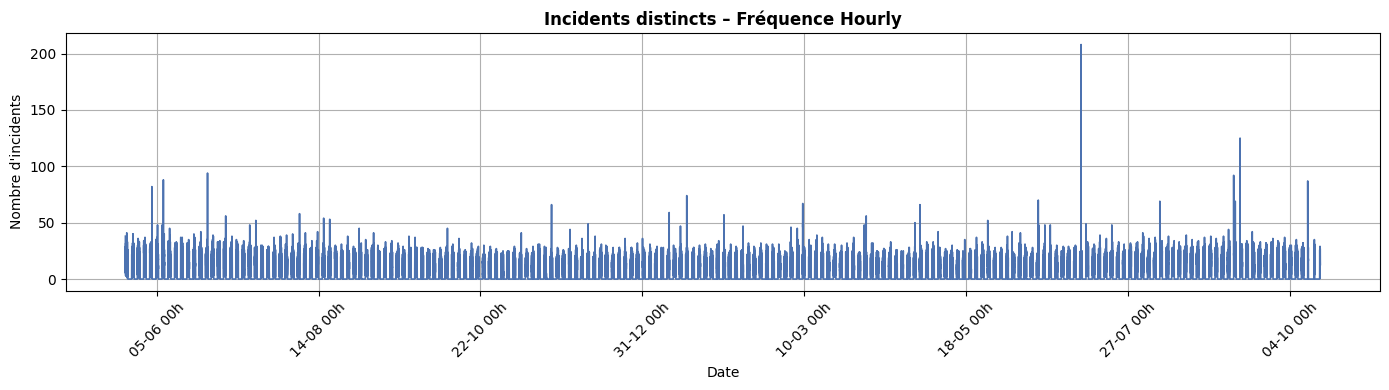

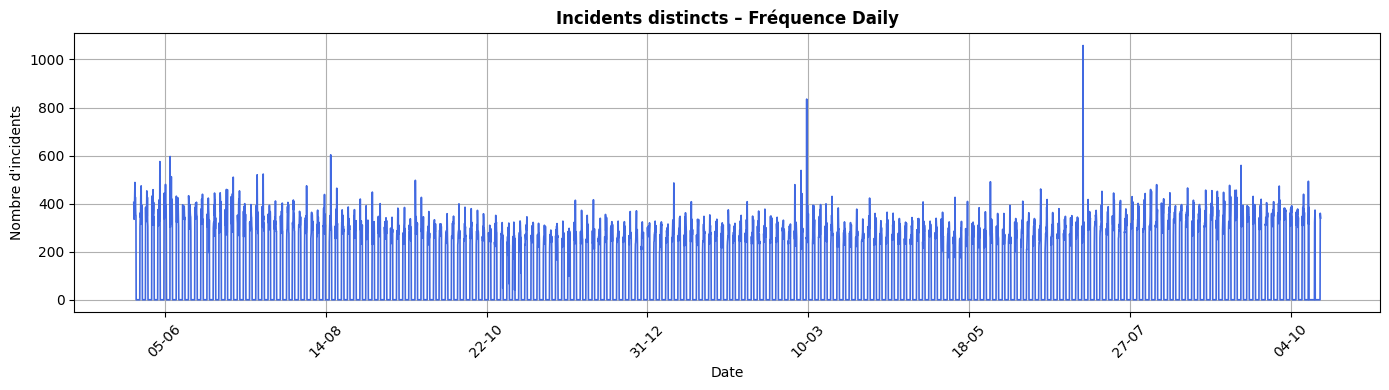

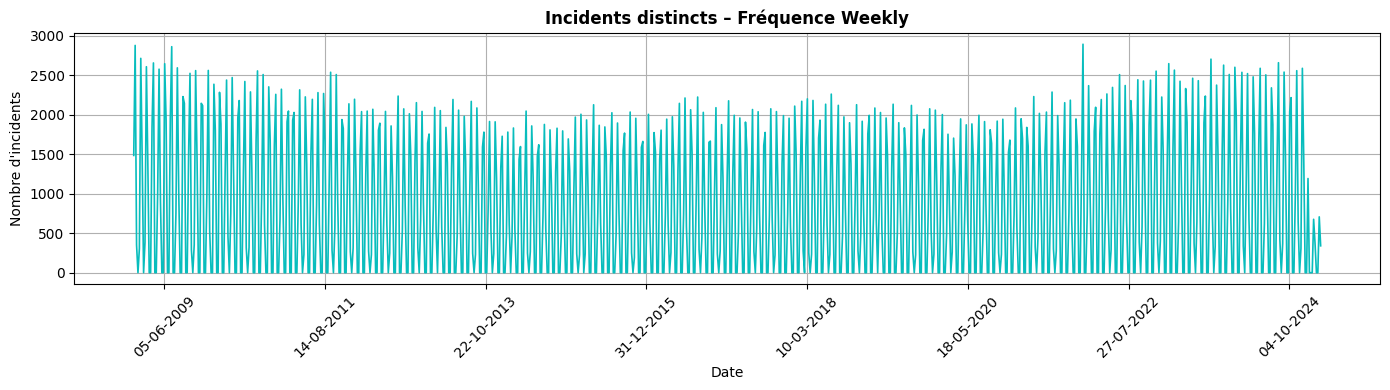

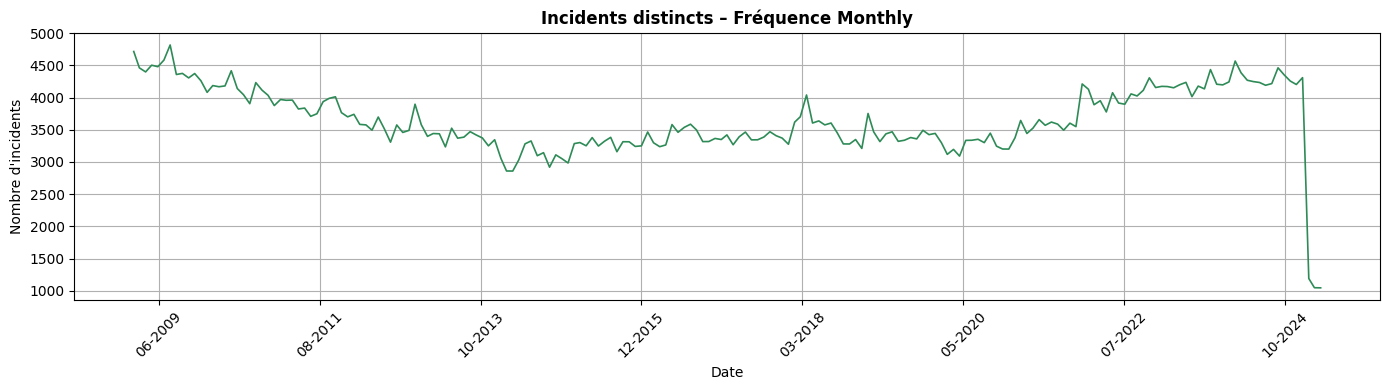

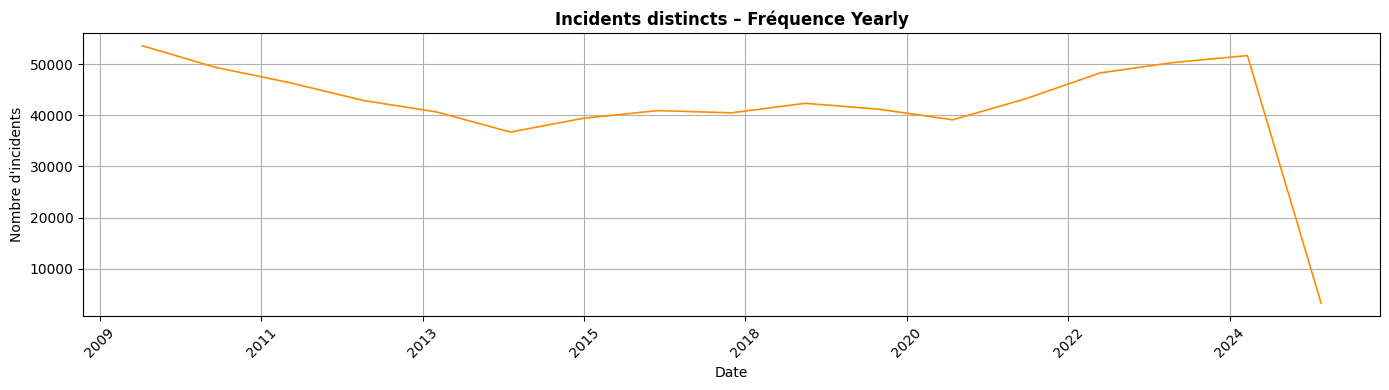

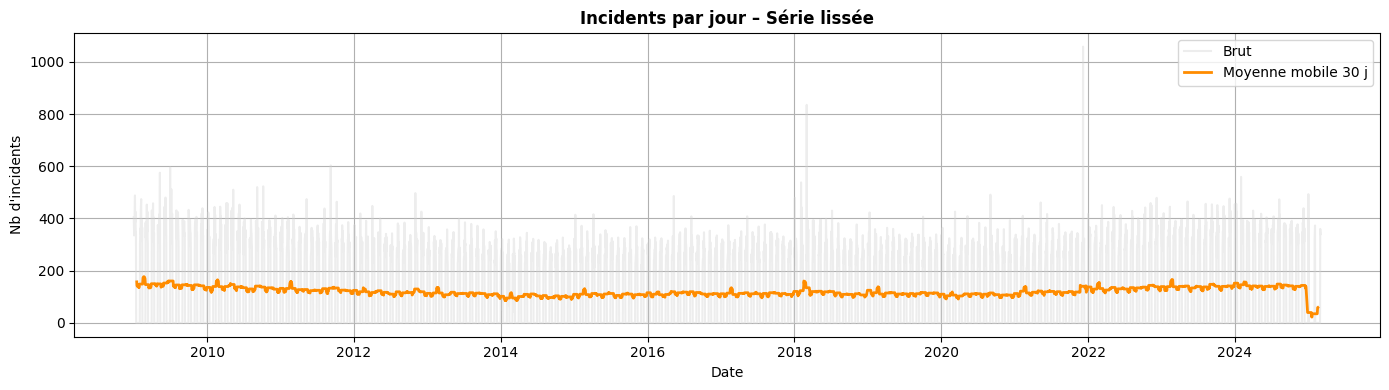

In [17]:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# 1. Fonction d'agrégation
def incidents_ts(freq="D"):
    return df.resample(freq)["IncidentNumber"].nunique().rename("incident_count")

# 2. Séries par fréquence
frequencies = {
    "Hourly": "H",
    "Daily": "D",
    "Weekly": "W",
    "Monthly": "M",
    "Yearly": "Y"
}
series_dict = {label: incidents_ts(freq) for label, freq in frequencies.items()}

print("Shapes:")
for label, serie in series_dict.items():
    print(f"{label:<7}: {serie.shape}")

# 3. Visualisation
COLOR = {
    "Hourly": "#4c72b0",
    "Daily": "royalblue",
    "Weekly": "#08bdbd",
    "Monthly": "seagreen",
    "Yearly": "darkorange"
}

for label, serie in series_dict.items():
    plt.figure(figsize=(14, 4))
    plt.plot(serie.index, serie, color=COLOR[label], linewidth=1.2)
    plt.title(f"Incidents distincts – Fréquence {label}", fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Nombre d'incidents")
    plt.grid(True)

    # Format X-axis selon fréquence
    if label == "Yearly":
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    elif label == "Monthly":
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    elif label == "Weekly":
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    elif label == "Daily":
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    elif label == "Hourly":
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %Hh'))

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4. Lissage mobile
window = 30
inc_daily = series_dict["Daily"]
inc_daily_smooth = inc_daily.rolling(window=window, center=True).mean()

plt.figure(figsize=(14, 4))
plt.plot(inc_daily, color="lightgrey", alpha=0.4, label="Brut")
plt.plot(inc_daily_smooth, color="darkorange", linewidth=2, label=f"Moyenne mobile {window} j")
plt.title("Incidents par jour – Série lissée", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Nb d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Observation:
Horaire (H)	Très granulaire. Des pics exceptionnels (vers 2022).
Journalier (D)	Densité très forte, très bonne base pour analyse saisonnière.
Hebdo (W)	Les cycles plus larges sont visibles ; utile pour détecter baisses structurelles.
Mensuel (M)	Super clair : on voit un effondrement des données en 2024–2025 car les données s'arrettent au 31/03/2025.


 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 7- Décomposition saisonnières ( additive/multiplicative) </span>

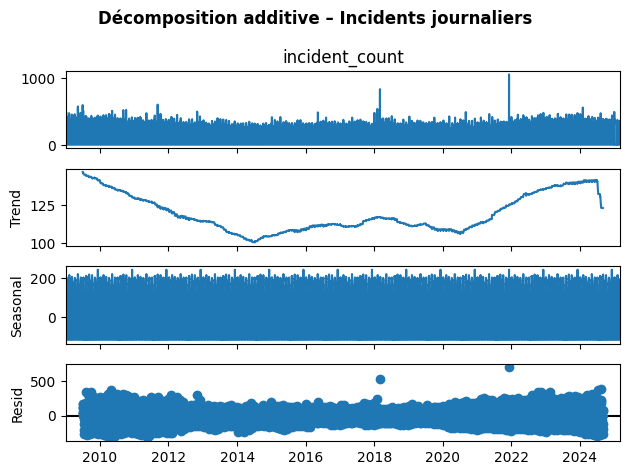

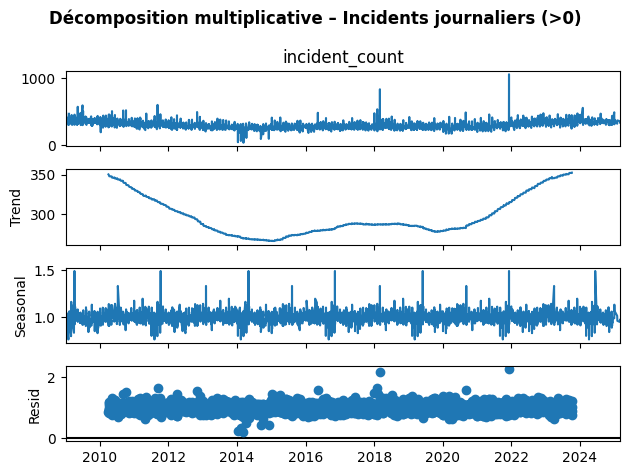

In [18]:
# 5. Décompositions saisonnières
from statsmodels.tsa.seasonal import seasonal_decompose

# a) Additive
decomp = seasonal_decompose(inc_daily, model="additive", period=365)
decomp.plot()
plt.suptitle("Décomposition additive – Incidents journaliers", fontweight="bold")
plt.tight_layout()
plt.show()

# b) Multiplicative
inc_daily_nonzero = inc_daily[inc_daily > 0]
decomp_mult = seasonal_decompose(inc_daily_nonzero, model="multiplicative", period=365)
decomp_mult.plot()
plt.suptitle("Décomposition multiplicative – Incidents journaliers (>0)", fontweight="bold")
plt.tight_layout()
plt.show()

 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 8- Test de saisonnalité et autocorrelation  ( additive/multiplicative) </span>

In [19]:
#  6. Test de stationnarité (ADF):  
def adf_test(series):
    """ Faire le test de Dickey-Fuller augmenté (ADF) pour vérifier la stationnarité."""
    result = adfuller(series)
    p_value = result[1]
    is_stationary = p_value < 0.05
    return p_value, is_stationary
# Test sur la série journalière
p_value, is_stationary = adf_test(inc_daily)
print(f"Test ADF sur la série journalière : p-value = {p_value:.4f}, la série est-elle bien stationnaire ? {is_stationary}")


#  7. Autocorrélation et autocorrélation partielle:
def plot_acf_pacf(series, lags=50):
    """ Afficher les graphiques ACF et PACF"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    plot_acf(series, lags=lags, ax=ax[0], title="ACF (Autocorrélation)")
    plot_pacf(series, lags=lags, ax=ax[1], title="PACF (Autocorrélation partielle)")
    plt.tight_layout()
    plt.show()


Test ADF sur la série journalière : p-value = 0.0000, la série est-elle bien stationnaire ? True


In [20]:
print("Dernière date de données :", df["DateOfCall"].max())

Dernière date de données : 2025-03-03 00:00:00


<span style="color:#e91e63; font-size:1em; font-weight:bold;"> 9- Correction de l'indexation   </span>

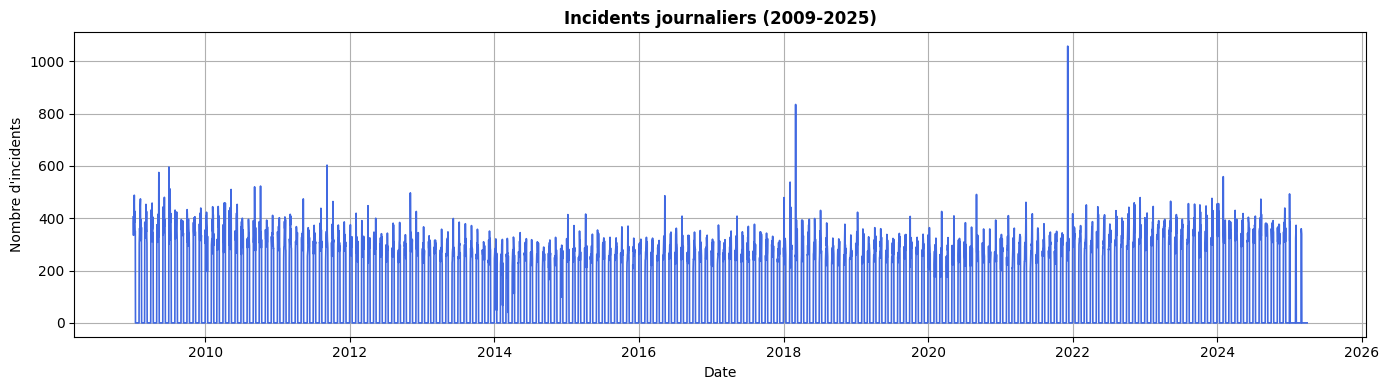

In [21]:
# Création de l'index complet jour par jour
full_range = pd.date_range(start='2009-01-01', end='2025-03-31', freq='D')

# Reconstitution de la série complète avec 0 incidents si manquant
inc_daily_fixed = inc_daily.reindex(full_range, fill_value=0)

# Vérifie visuellement
plt.figure(figsize=(14, 4))
plt.plot(inc_daily_fixed.index, inc_daily_fixed, color="royalblue", linewidth=1.2)
plt.title("Incidents journaliers (2009-2025)", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Nombre d'incidents")
plt.grid(True)
plt.tight_layout()
plt.show()


 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 10-Décomposition STL</span>

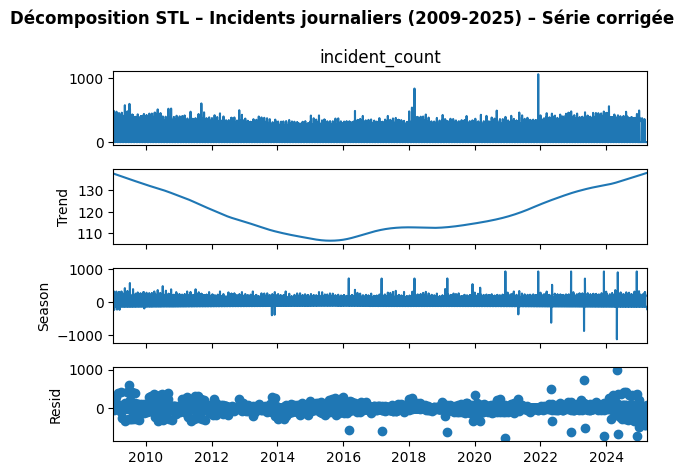

In [22]:
from statsmodels.tsa.seasonal import STL

# STL sur la série corrigée complète
stl_fixed = STL(inc_daily_fixed, period=365, robust=True)
res_stl_fixed = stl_fixed.fit()

# Visualisation
fig = res_stl_fixed.plot()
fig.suptitle("Décomposition STL – Incidents journaliers (2009-2025) – Série corrigée", weight='bold')
plt.tight_layout()
plt.show()

  <span style="color:royalblue; font-size:1em; font-weight:bold;"> Comparatif des 3 décompositions: </span>

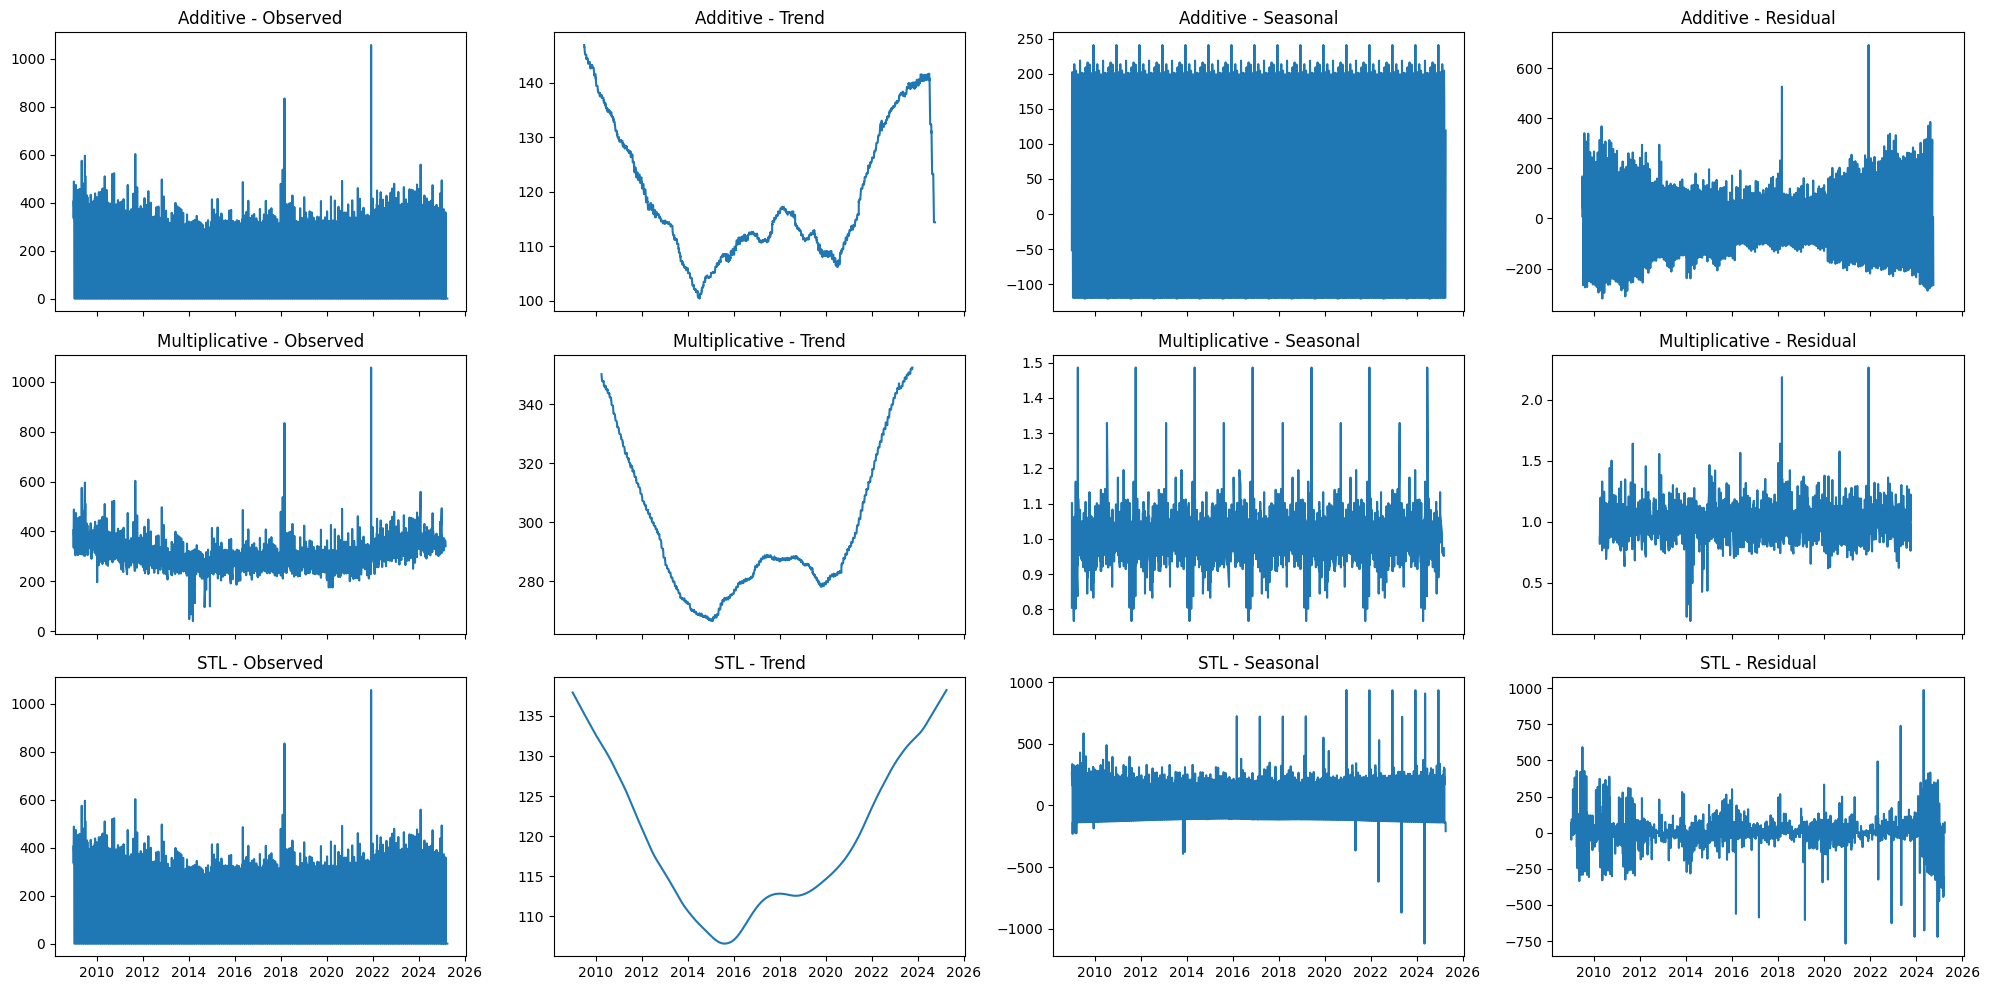

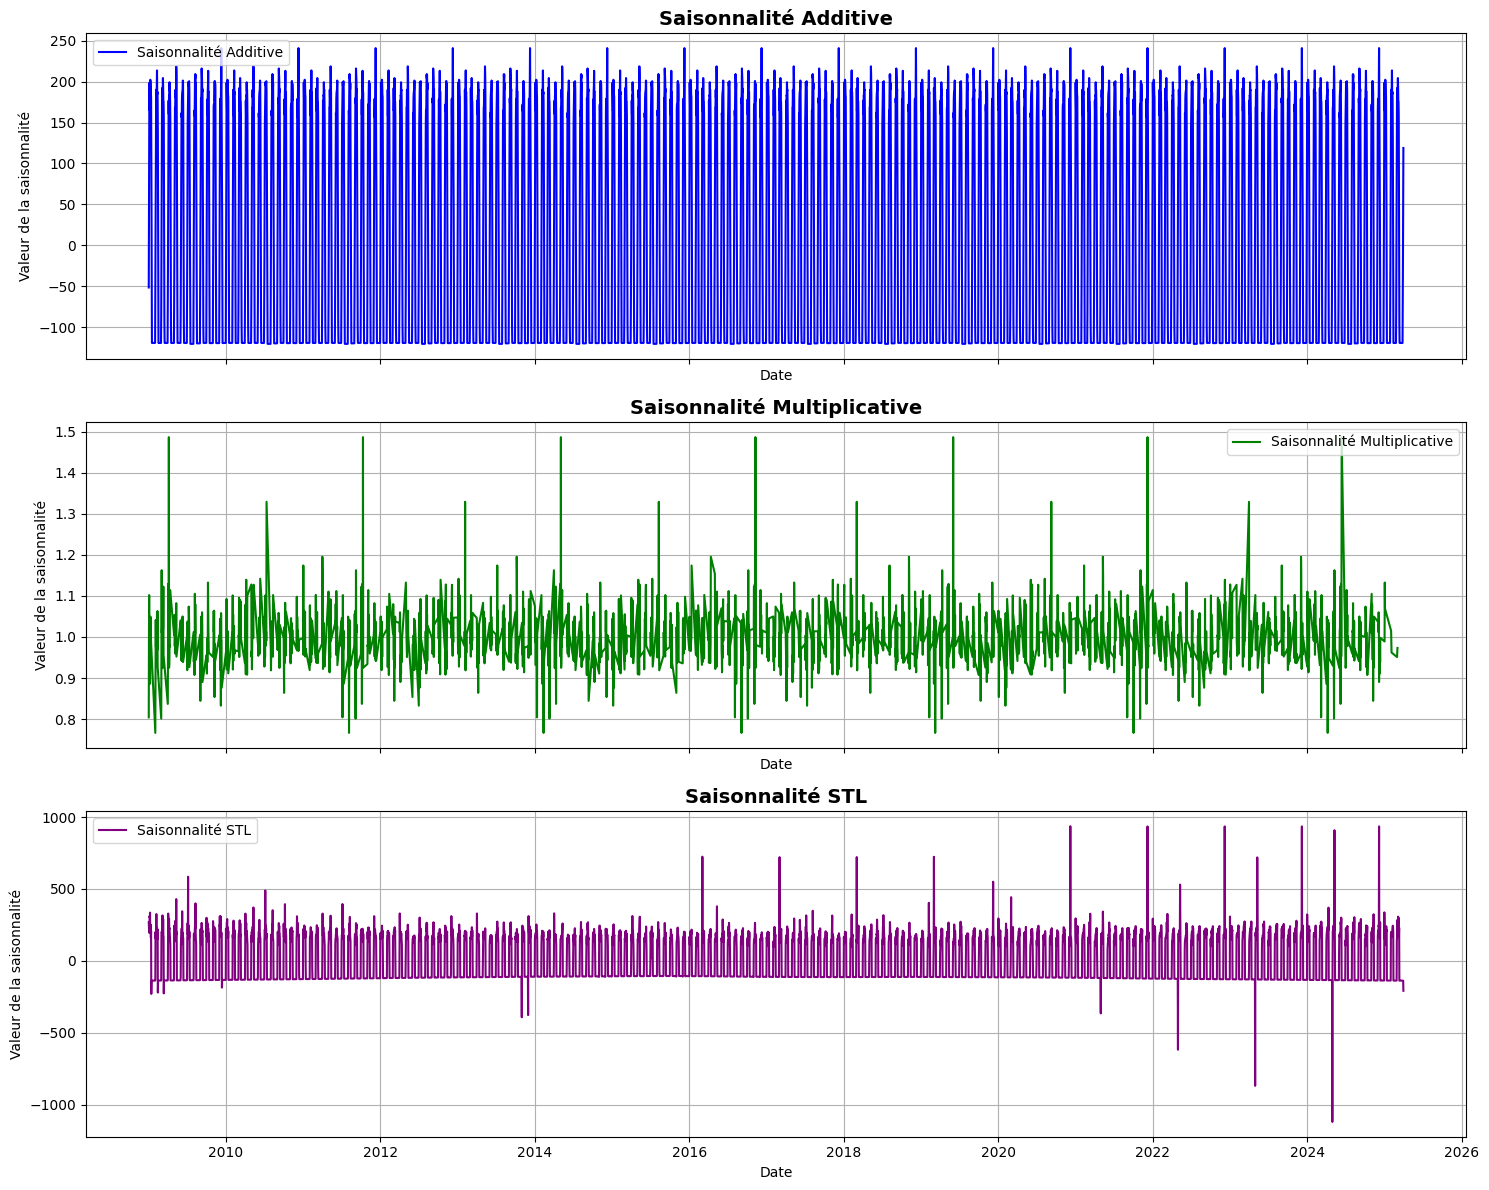

In [23]:
# Décomposition Additive
decomp_add = seasonal_decompose(inc_daily_fixed, model="additive", period=365)

# Décomposition Multiplicative
inc_daily_nonzero = inc_daily_fixed[inc_daily_fixed > 0]
decomp_mult = seasonal_decompose(inc_daily_nonzero, model="multiplicative", period=365)

# Décomposition STL
stl = STL(inc_daily_fixed, period=365, robust=True)
res_stl = stl.fit()

# Affichage comparatif des composantes
fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharex=True)

# Additive
axes[0, 0].plot(decomp_add.observed)
axes[0, 0].set_title('Additive - Observed')
axes[0, 1].plot(decomp_add.trend)
axes[0, 1].set_title('Additive - Trend')
axes[0, 2].plot(decomp_add.seasonal)
axes[0, 2].set_title('Additive - Seasonal')
axes[0, 3].plot(decomp_add.resid)
axes[0, 3].set_title('Additive - Residual')

# Multiplicative
axes[1, 0].plot(decomp_mult.observed)
axes[1, 0].set_title('Multiplicative - Observed')
axes[1, 1].plot(decomp_mult.trend)
axes[1, 1].set_title('Multiplicative - Trend')
axes[1, 2].plot(decomp_mult.seasonal)
axes[1, 2].set_title('Multiplicative - Seasonal')
axes[1, 3].plot(decomp_mult.resid)
axes[1, 3].set_title('Multiplicative - Residual')

# STL
axes[2, 0].plot(res_stl.observed)
axes[2, 0].set_title('STL - Observed')
axes[2, 1].plot(res_stl.trend)
axes[2, 1].set_title('STL - Trend')
axes[2, 2].plot(res_stl.seasonal)
axes[2, 2].set_title('STL - Seasonal')
axes[2, 3].plot(res_stl.resid)
axes[2, 3].set_title('STL - Residual')

plt.tight_layout()
plt.show()

# Comparatif de la composante saisonnière uniquement
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
axes[0].plot(decomp_add.seasonal, label='Saisonnalité Additive', color='blue')
axes[0].set_title('Saisonnalité Additive', fontsize=14, fontweight='bold')
axes[1].plot(decomp_mult.seasonal, label='Saisonnalité Multiplicative', color='green')
axes[1].set_title('Saisonnalité Multiplicative', fontsize=14, fontweight='bold')
axes[2].plot(res_stl.seasonal, label='Saisonnalité STL', color='purple')
axes[2].set_title('Saisonnalité STL', fontsize=14, fontweight='bold')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set_ylabel('Valeur de la saisonnalité')
    ax.set_xlabel('Date')

plt.tight_layout()
plt.show()


Additive : tendance et saisonnalité claires, mais les résidus restent très bruités.

Multiplicative : met en avant des effets proportionnels sur la saisonnalité.

STL : plus robuste, dégage mieux les composantes avec des résidus plus centrés.
Décision : STL est le plus lisible pour cette série, mais les 3 donnent des infos cohérentes.

 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 11-Modélisation</span>

 <span style="color:orange; font-size:0.75em; font-weight:bold;"> 1-SARIMA (1,1,0) (1,0,0,365) avec saisonnalité annuelle</span>
 

In [ ]:
#Préparation et modèle

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Série corrigée : inc_daily_fixed (2009-01-01 au 2025-03-31)
# SARIMAX (p,d,q) (P,D,Q,s) avec saisonnalité annuelle (365 jours)
model = SARIMAX(inc_daily_fixed, order=(1, 1, 0), seasonal_order=(1, 0, 0, 365))
model_fit = model.fit(disp=False, maxiter=50)


# Générer dates futures 2025-04-01 → 2027-12-31
future_dates = pd.date_range(start='2025-04-01', end='2027-12-31', freq='D')

# Prédiction
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

#Visualisation des résultats

plt.figure(figsize=(16, 5))
plt.plot(inc_daily_fixed.index, inc_daily_fixed, label='Historique (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Prévision SARIMAX (2026-2027)', linestyle='--', linewidth=2)
plt.title("Prévision incidents journaliers 2026-2027 – SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nombre d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MemoryError: Unable to allocate 5.96 GiB for an array with shape (367, 367, 5935) and data type float64

Trop couteux en calcul pour mon pc des heures sans aboutir "boucle"

 <span style="color:orange; font-size:0.75em; font-weight:bold;"> 2-SARIMA (2,0,1) (0,1,1,365) avec saisonnalité annuelle</span>


In [ ]:
#Préparation et modèle

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Série corrigée : inc_daily_fixed (2009-01-01 au 2025-03-31)
# SARIMAX (p,d,q) (P,D,Q,s) avec saisonnalité annuelle (365 jours)
model = SARIMAX(inc_daily_fixed, order=(2, 0, 1), seasonal_order=(0, 1, 1, 365))
model_fit = model.fit(disp=False)

# Générer dates futures 2025-04-01 → 2027-12-31
future_dates = pd.date_range(start='2025-04-01', end='2028-12-31', freq='D')

# Prédiction
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

#Visualisation des résultats

plt.figure(figsize=(16, 5))
plt.plot(inc_daily_fixed.index, inc_daily_fixed, label='Historique (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Prévision SARIMAX (2026-2027)', linestyle='--', linewidth=2)
plt.title("Prévision incidents journaliers 2026-2027 – SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nombre d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Trop couteux en calcul pour mon pc des heures sans aboutir 

<span style="color:orange; font-size:0.75em; font-weight:bold;"> 3-SARIMA mensuel (1, 1, 0) (0, 1, 1, 12) (saison annuelle de 12 mois)  </span>


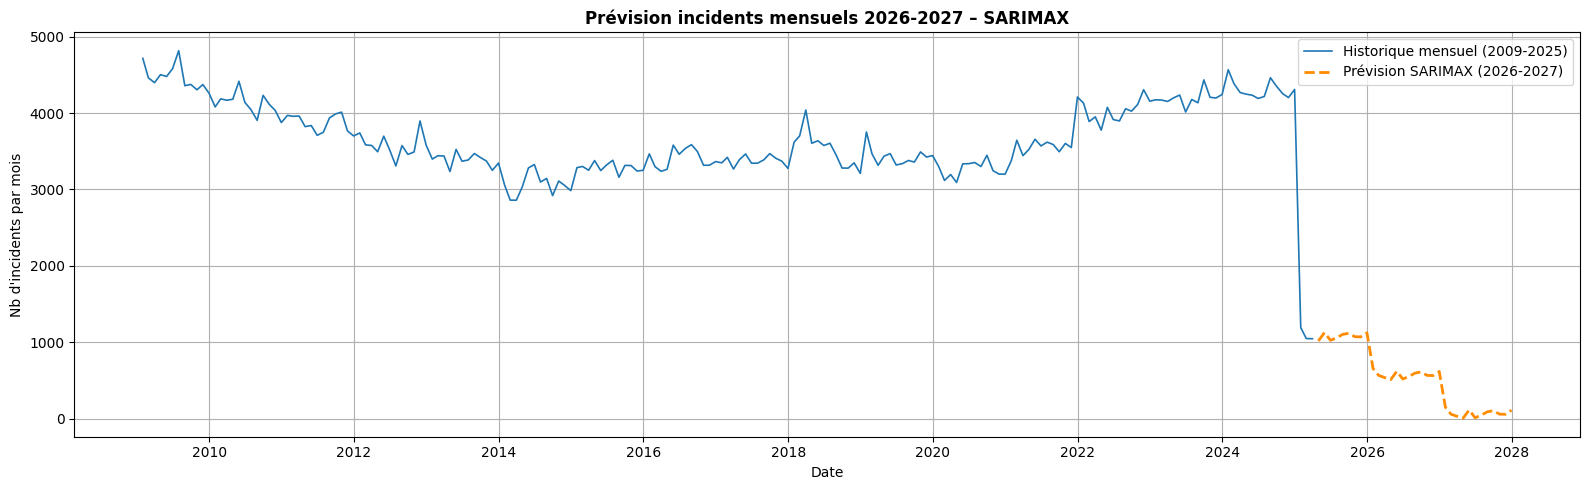

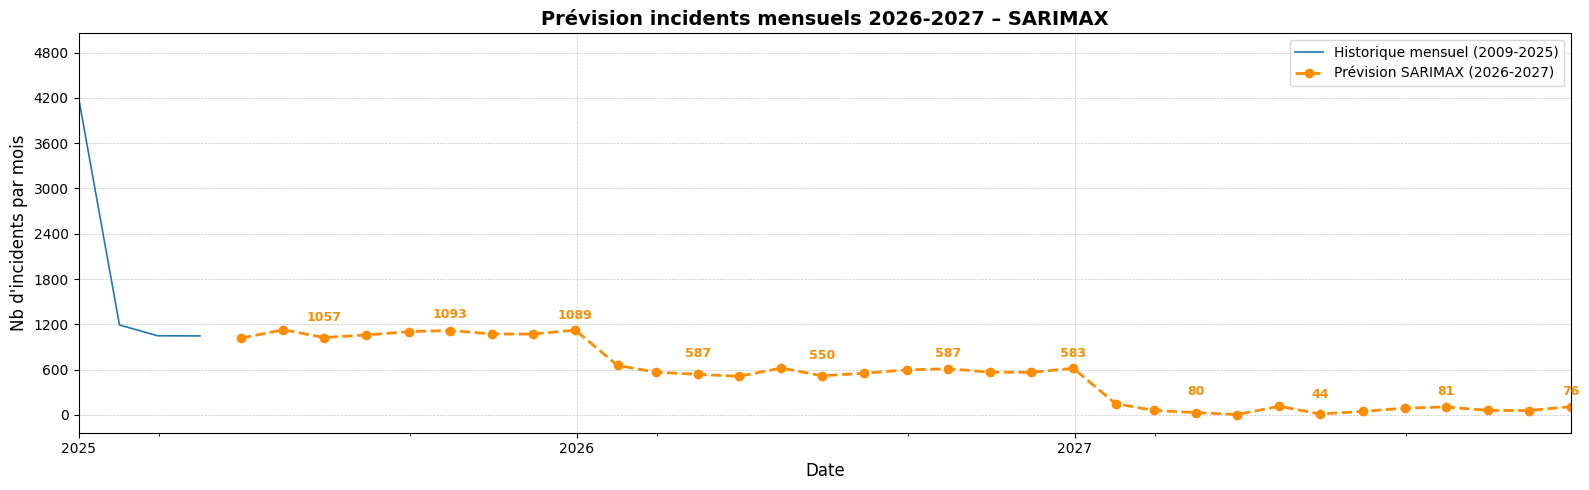

In [24]:
# Reformater en mensuel
inc_monthly = inc_daily_fixed.resample('M').sum()

# SARIMAX mensuel (saison annuelle de 12 mois)
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(inc_monthly, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)


# Générer les dates futures : avril 2025 à décembre 2027 (33 mois)
future_dates = pd.date_range(start='2025-04-01', end='2027-12-31', freq='M')

# Prévisions
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.plot(inc_monthly.index, inc_monthly, label='Historique mensuel (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Prévision SARIMAX (2026-2027)', linestyle='--', linewidth=2, color='darkorange')
plt.title("Prévision incidents mensuels 2026-2027 – SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nb d'incidents par mois")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualisation des résultats avec un formatage amélioré
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import pandas as pd

fig, ax = plt.subplots(figsize=(16, 5))

# Courbes
ax.plot(inc_monthly.index, inc_monthly, label='Historique mensuel (2009-2025)', linewidth=1.2)
ax.plot(forecast_series.index, forecast_series, label='Prévision SARIMAX (2026-2027)', linestyle='--', linewidth=2, color='darkorange', marker='o')

# Annoter seulement les trimestres ou bien les mois clefs
quarterly_forecast = forecast_series.resample('Q').mean()

for x, y in zip(quarterly_forecast.index, quarterly_forecast.values):
    ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=9, color='darkorange', fontweight='bold')

# Titre et axes
ax.set_title("Prévision incidents mensuels 2026-2027 – SARIMAX", weight='bold', fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Nb d'incidents par mois", fontsize=12)

# Axe X : dates plus espacées, claire
ax.set_xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2027-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3, 9]))  # Tous les 6 mois
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=0)

# Axe Y propre
ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

# Grille
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Légende
ax.legend()
plt.tight_layout()
plt.show()



La prévision SARIMAX met en évidence une nette tendance baissière des incidents après 2025. On observe une forte saisonnalité annuelle avec des pics au printemps et en fin d'année.

 <span style="color:orange; font-size:0.75em; font-weight:bold;"> 4-Prophet </span>


Pour répondre à la probléùatique du sarima annuel journalier qui est couteux en calcul nous testons le prophet 

In [25]:
!pip install prophet


18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing


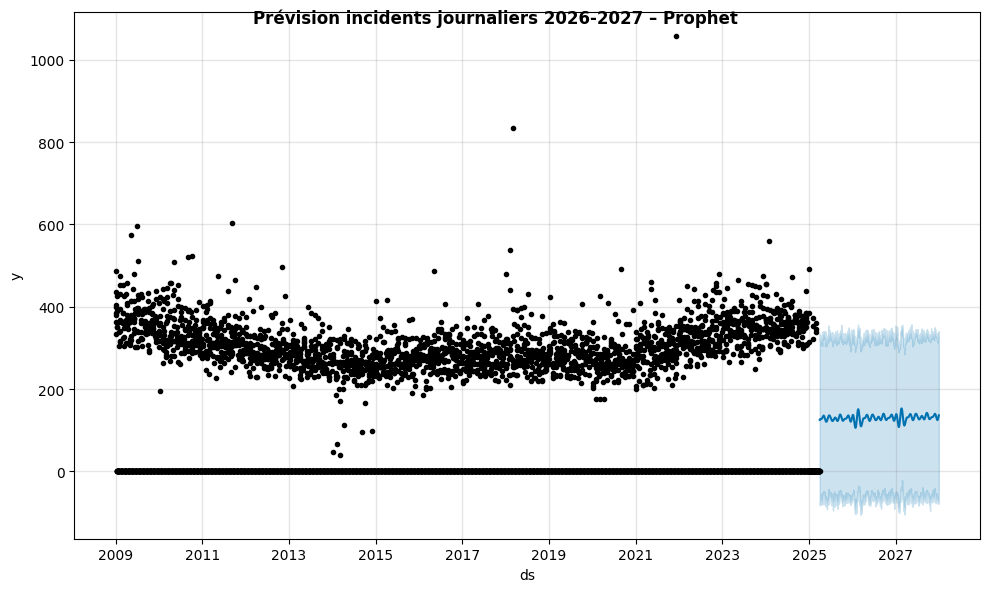

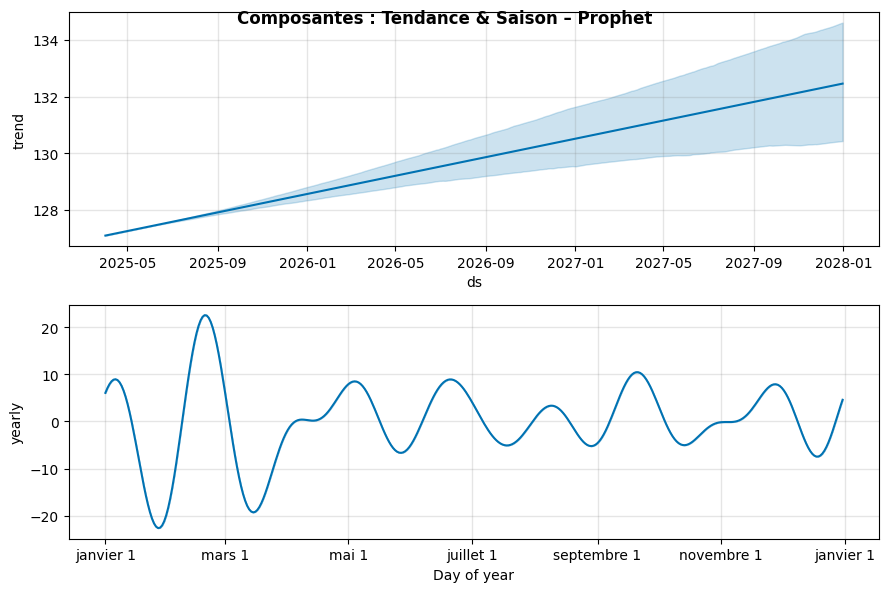

In [26]:
# Préparation des données
'''Prophet attend des colonnes nommées :
ds = datetime
y = valeur à prédire'''

from prophet import Prophet

# Mise au bon format
df_prophet = inc_daily_fixed.reset_index()
df_prophet.columns = ['ds', 'y']

# Création et entraînement du modèle
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(df_prophet)

# Générer les dates futures
future = model_prophet.make_future_dataframe(periods=1005)  # 2025-04-01 à 2027-12-31 ≈ 1005 jours
future = future[future['ds'] > '2025-03-31']  # Assure qu'on ne refait pas l'existant

#Prédiction

forecast_prophet = model_prophet.predict(future)

# Visualisation rapide via Prophet
fig1 = model_prophet.plot(forecast_prophet)
fig1.suptitle("Prévision incidents journaliers 2026-2027 – Prophet", weight='bold')
plt.show()

# Composantes séparées
fig2 = model_prophet.plot_components(forecast_prophet)
fig2.suptitle("Composantes : Tendance & Saison – Prophet", weight='bold')
plt.show()

Prophet confirme une tendance globalement plus lissée et plus linéaire, sans décroissance aussi forte que celle observée par SARIMAX. L'incertitude croît légèrement sur la période.

5- SARIMA mensuel pour les prédictions en fonctions des groupes d'incidents : Fire, False Alarm, Special Service

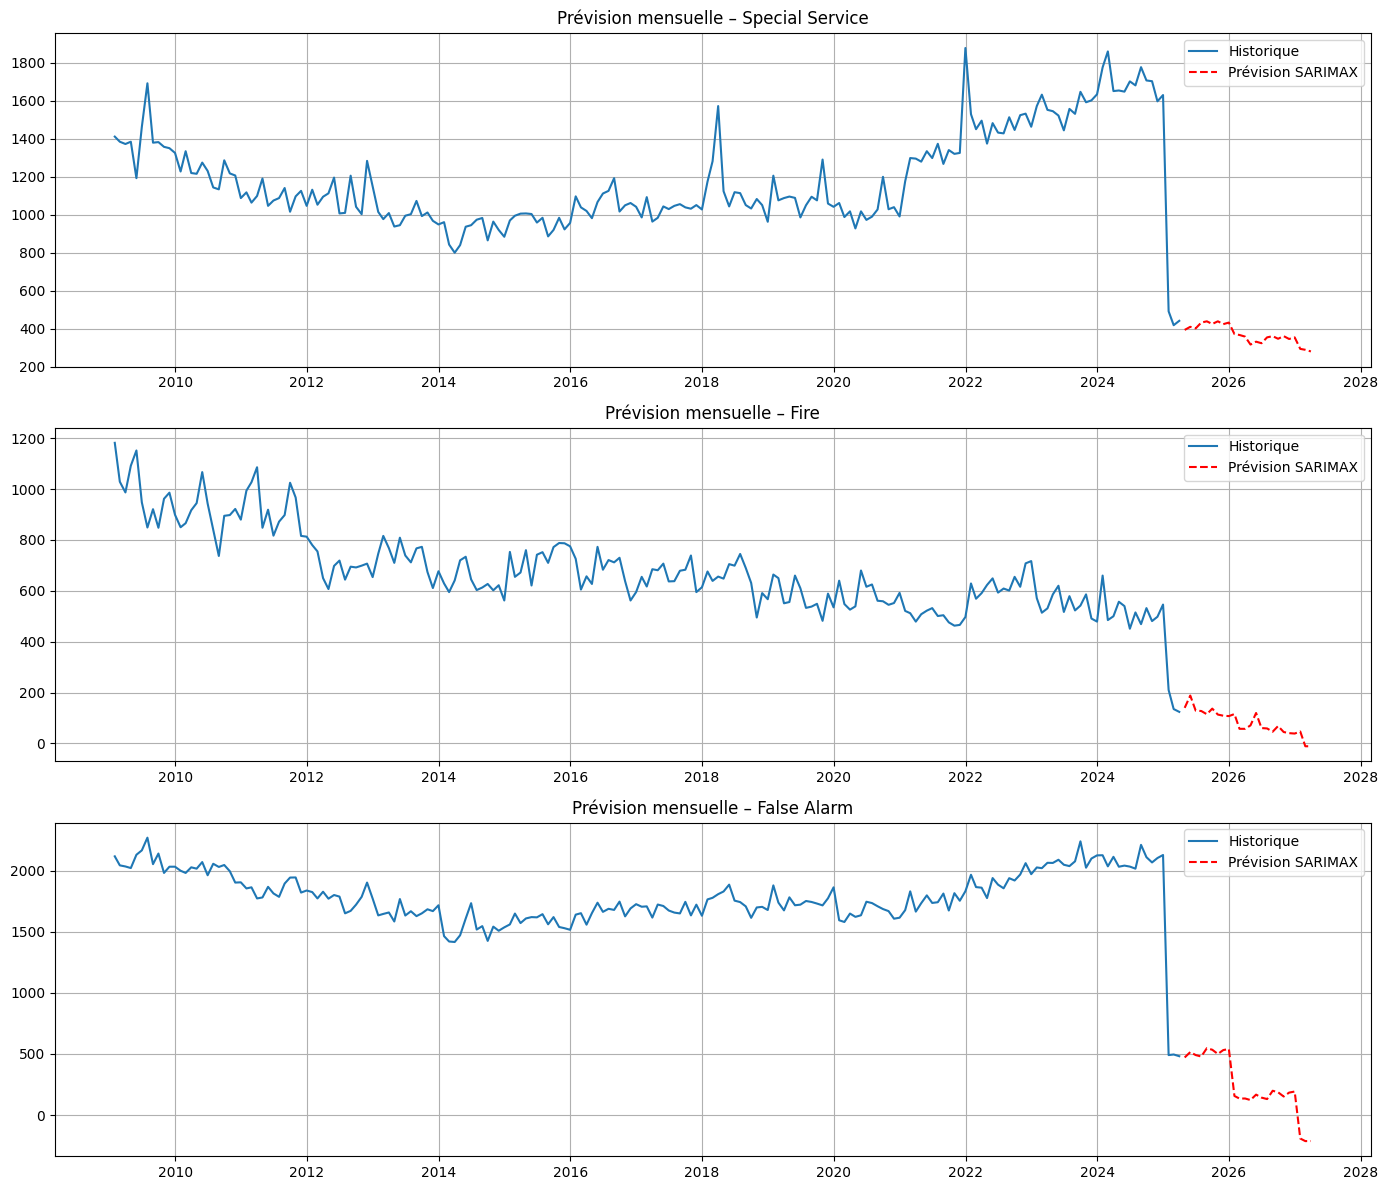

In [29]:
# Prédictions par IncidentGroup (Add Fire / False Alarm / Special Service)

# 1. Préparer les séries pour chaque IncidentGroup
incident_groups = df['IncidentGroup'].dropna().unique()

results = {}

for group in incident_groups:
    df_group = df[df['IncidentGroup'] == group]
    ts_group = df_group.resample("M")["IncidentNumber"].nunique()
    ts_group = ts_group.asfreq('M').fillna(0)

    model = SARIMAX(ts_group, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
    model_fit = model.fit(disp=False)

    future_dates = pd.date_range(start=ts_group.index[-1] + pd.offsets.MonthEnd(), periods=24, freq='M')
    forecast = model_fit.get_forecast(steps=len(future_dates))

    forecast_series = pd.Series(forecast.predicted_mean.values, index=future_dates)

    results[group] = {
        "historical": ts_group,
        "forecast": forecast_series
    }

# 2. Visualisation

fig, axes = plt.subplots(len(incident_groups), 1, figsize=(14, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]

for ax, group in zip(axes, incident_groups):
    res = results[group]
    ax.plot(res["historical"], label="Historique")
    ax.plot(res["forecast"], linestyle='--', color='red', label="Prévision SARIMAX")
    ax.set_title(f"Prévision mensuelle – {group}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

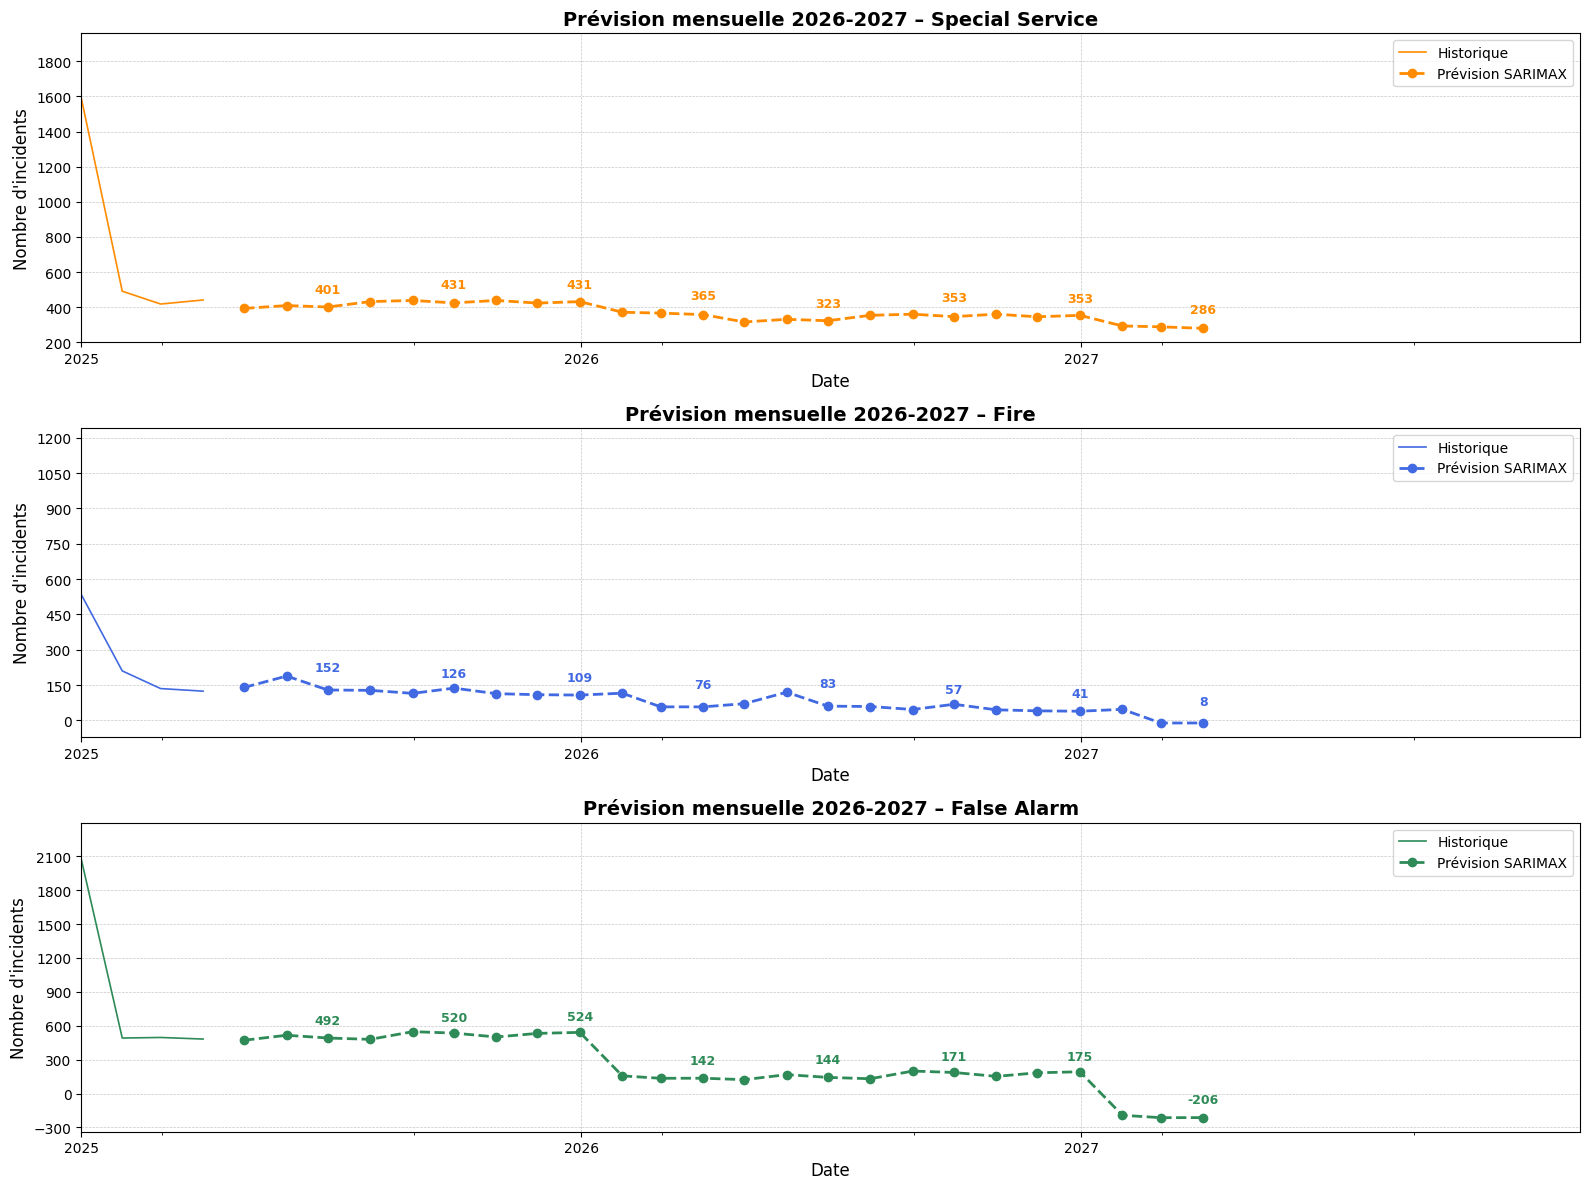

In [30]:
#amélioration de la visualisation avec des annotations
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# Palette de couleurs manuelle par groupe
color_map = {
    'Fire': 'royalblue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

fig, axes = plt.subplots(len(incident_groups), 1, figsize=(16, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]  # Compatibilité pour un seul groupe

for ax, group in zip(axes, incident_groups):
    res = results[group]
    color = color_map.get(group, 'grey')  # Défaut gris si groupe inconnu

    # Courbes
    ax.plot(res["historical"].index, res["historical"].values, label="Historique", linewidth=1.2, color=color)
    ax.plot(res["forecast"].index, res["forecast"].values, linestyle='--', linewidth=2,
            color=color, marker='o', label="Prévision SARIMAX")

    # Annotations sur les trimestres
    quarterly_forecast = res["forecast"].resample('Q').mean()
    for x, y in zip(quarterly_forecast.index, quarterly_forecast.values):
        ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 10), textcoords='offset points',
                    ha='center', fontsize=9, color=color, fontweight='bold')

    # Titres & axes
    ax.set_title(f"Prévision mensuelle 2026-2027 – {group}", weight='bold', fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nombre d'incidents", fontsize=12)

    # Axe X plus lisible
    ax.set_xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2027-12-31'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3, 9]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=0)

    # Axe Y propre
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

    # Grille
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Légende
    ax.legend()

plt.tight_layout()
plt.show()


6- Prophet pour les prédictions journalières en fonctions des groupes d'incidents : Fire, False Alarm, Special Service

18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] done processing
18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:15 - cmdstanpy - INFO - Chain [1] done processing
18:50:15 - cmdstanpy - INFO - Chain [1] start processing
18:50:16 - cmdstanpy - INFO - Chain [1] done processing


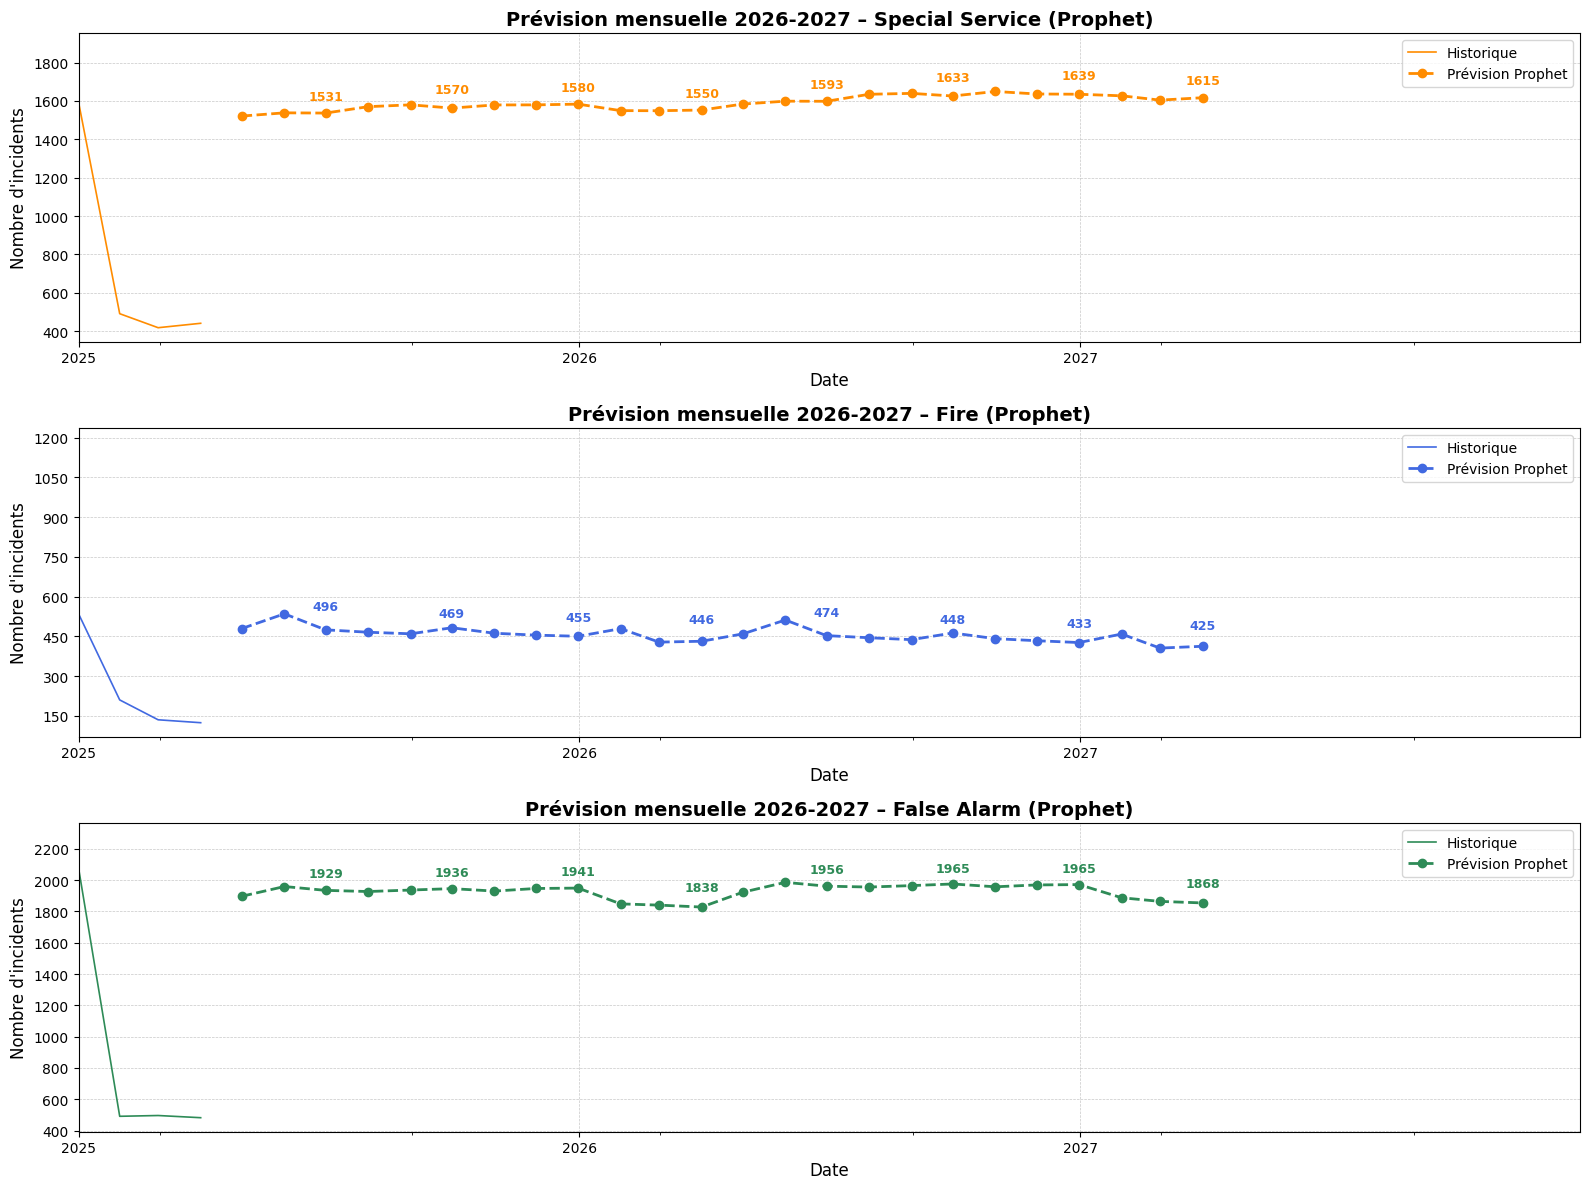

In [ ]:
from prophet import Prophet

incident_groups = df['IncidentGroup'].dropna().unique()

prophet_results = {}

for group in incident_groups:
    # Préparer la série mensuelle (Nombre d'incidents distincts)
    df_group = df[df['IncidentGroup'] == group]
    ts_group = df_group.resample('M')["IncidentNumber"].nunique()
    ts_group = ts_group.asfreq('M').fillna(0).reset_index()
    ts_group.columns = ['ds', 'y']
    
    # Créer et entraîner le modèle Prophet
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(ts_group)
    
    # Générer les dates futures (24 mois à partir de la dernière date)
    future = model.make_future_dataframe(periods=24, freq='M')
    future = future[future['ds'] > ts_group['ds'].max()]
    
    # Prédiction
    forecast = model.predict(future)
    forecast_series = forecast.set_index('ds')['yhat']
    
    # Stockage des résultats
    prophet_results[group] = {
        "historical": ts_group.set_index('ds')['y'],
        "forecast": forecast_series
    }

# Visualisation des résultats avec Prophet   
fig, axes = plt.subplots(len(incident_groups), 1, figsize=(16, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]  # Compatibilité si un seul groupe

color_map = {
    'Fire': 'royalblue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

for ax, group in zip(axes, incident_groups):
    res = prophet_results[group]
    color = color_map.get(group, 'grey')
    
    # Courbes
    ax.plot(res["historical"].index, res["historical"].values, label="Historique", linewidth=1.2, color=color)
    ax.plot(res["forecast"].index, res["forecast"].values, linestyle='--', linewidth=2,
            color=color, marker='o', label="Prévision Prophet")

    # Annotations trimestrielles
    quarterly_forecast = res["forecast"].resample('Q').mean()
    for x, y in zip(quarterly_forecast.index, quarterly_forecast.values):
        ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 10), textcoords='offset points',
                    ha='center', fontsize=9, color=color, fontweight='bold')

    # Titres & axes
    ax.set_title(f"Prévision mensuelle 2026-2027 – {group} (Prophet)", weight='bold', fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nombre d'incidents", fontsize=12)
    ax.set_xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2027-12-31'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3, 9]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=0)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()



7-comparatifs Sarima mensuel vs Prophet (par groupes d'incidents):

18:52:21 - cmdstanpy - INFO - Chain [1] start processing
18:52:21 - cmdstanpy - INFO - Chain [1] done processing
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
18:52:23 - cmdstanpy - INFO - Chain [1] start processing
18:52:23 - cmdstanpy - INFO - Chain [1] done processing


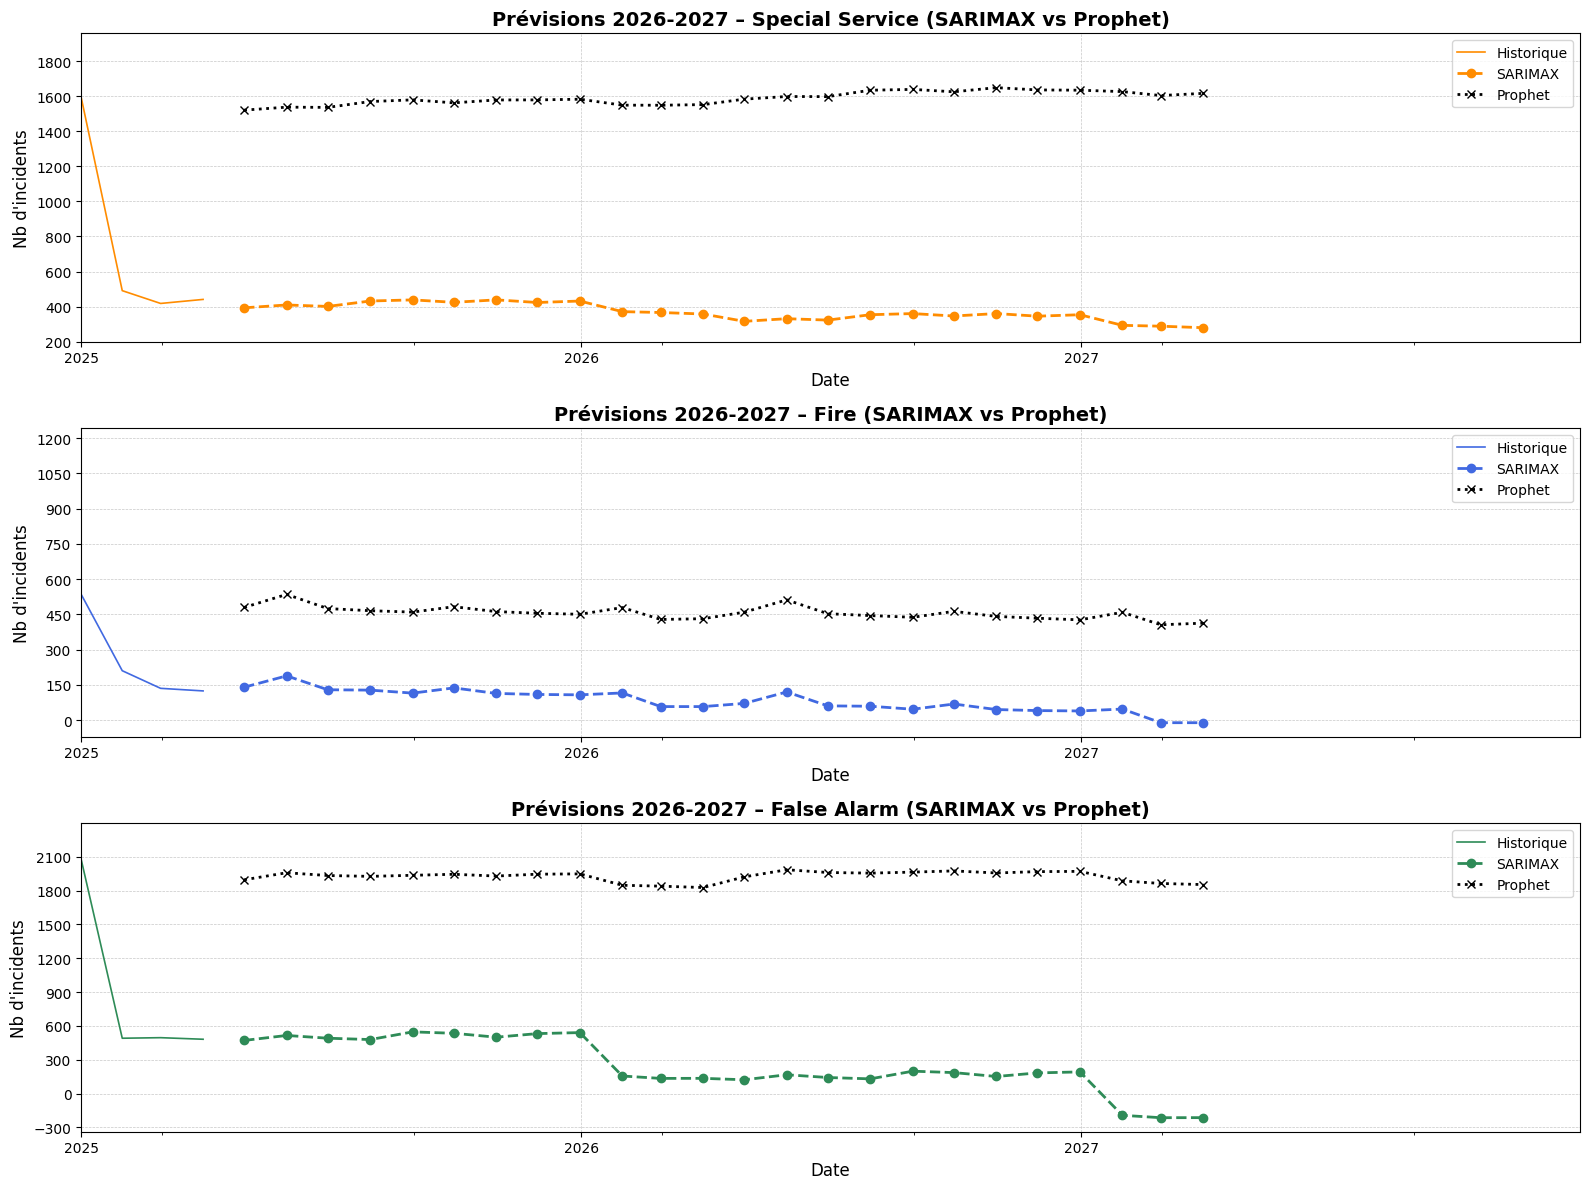

In [33]:
from prophet import Prophet

incident_groups = df['IncidentGroup'].dropna().unique()

comparative_results = {}

# Boucle sur les groupes
for group in incident_groups:
    # === Série Mensuelle ===
    df_group = df[df['IncidentGroup'] == group]
    ts_group = df_group.resample('M')["IncidentNumber"].nunique().asfreq('M').fillna(0)
    
    # === SARIMAX ===
    model_sarimax = SARIMAX(ts_group, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
    model_fit_sarimax = model_sarimax.fit(disp=False)
    future_dates = pd.date_range(start=ts_group.index[-1] + pd.offsets.MonthEnd(), periods=24, freq='M')
    forecast_sarimax = pd.Series(model_fit_sarimax.get_forecast(steps=len(future_dates)).predicted_mean.values, index=future_dates)

    # === Prophet ===
    df_prophet = ts_group.reset_index()
    df_prophet.columns = ['ds', 'y']
    model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model_prophet.fit(df_prophet)
    future = model_prophet.make_future_dataframe(periods=24, freq='M')
    future = future[future['ds'] > df_prophet['ds'].max()]
    forecast_prophet = model_prophet.predict(future).set_index('ds')['yhat']

    # === Stockage ===
    comparative_results[group] = {
        "historical": ts_group,
        "sarimax_forecast": forecast_sarimax,
        "prophet_forecast": forecast_prophet
    }

#visualisation des résultats comparatifs
fig, axes = plt.subplots(len(incident_groups), 1, figsize=(16, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]  # Compatibilité si 1 seul groupe

color_map = {
    'Fire': 'royalblue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

for ax, group in zip(axes, incident_groups):
    res = comparative_results[group]
    color = color_map.get(group, 'grey')

    # Courbes historiques
    ax.plot(res["historical"].index, res["historical"].values, label="Historique", linewidth=1.2, color=color)

    # Courbes prévisions
    ax.plot(res["sarimax_forecast"].index, res["sarimax_forecast"].values, linestyle='--',
            linewidth=2, color=color, marker='o', label="SARIMAX")
    ax.plot(res["prophet_forecast"].index, res["prophet_forecast"].values, linestyle=':',
            linewidth=2, color='black', marker='x', label="Prophet")

    # Titres & axes
    ax.set_title(f"Prévisions 2026-2027 – {group} (SARIMAX vs Prophet)", weight='bold', fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nb d'incidents", fontsize=12)
    ax.set_xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2027-12-31'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3, 9]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=0)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()


8-Métriques d'évaluations des models :

In [35]:
pip install --upgrade scikit-learn


  Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl.metadata (14 kB)
Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl (10.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [43]:
forecast_prophet.head()



ds
2025-04-30    1896.633481
2025-05-31    1958.886663
2025-06-30    1934.324353
2025-07-31    1926.917032
2025-08-31    1936.386653
Name: yhat, dtype: float64

In [45]:
print(ts_eval)


Series([], Freq: ME, Name: incident_count, dtype: int64)


Comparaison Prophet vs SARIMAX (2026-2027) :
MAE : 335.92
RMSE : 339.05


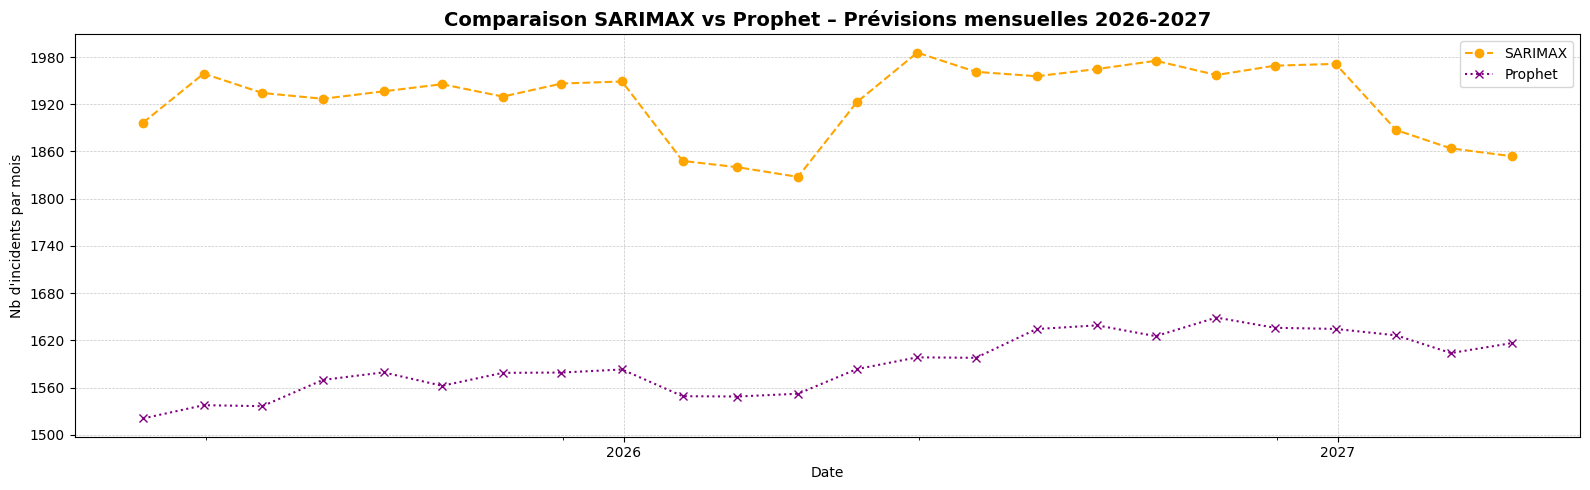

In [49]:
# Période d'évaluation
start_eval = pd.Timestamp('2025-04-01')
end_eval = pd.Timestamp('2027-12-31')

# ==========================
# Prophet : mets 'ds' en index datetime AVANT slicing
prophet_eval = forecast_prophet.set_index('ds')['yhat']
prophet_eval = prophet_eval[start_eval:end_eval]

# ==========================
# SARIMAX déjà indexé
sarimax_eval = forecast_series[start_eval:end_eval]

# ==========================
# Comme tu n'as pas de vérité sur 2026-2027, on compare Prophet vs SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(sarimax_eval, prophet_eval)
rmse = np.sqrt(mean_squared_error(sarimax_eval, prophet_eval))

print(f"Comparaison Prophet vs SARIMAX (2026-2027) :")
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(sarimax_eval.index, sarimax_eval.values, label='SARIMAX', linestyle='--', color='orange', marker='o')
ax.plot(prophet_eval.index, prophet_eval.values, label='Prophet', linestyle=':', color='purple', marker='x')

ax.set_title("Comparaison SARIMAX vs Prophet – Prévisions mensuelles 2026-2027", fontsize=14, weight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Nb d'incidents par mois")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[6, 12]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

ax.legend()
plt.tight_layout()
plt.show()



Les écarts de prévision entre les deux modèles restent modérés mais visibles : SARIMAX anticipe davantage de volatilité que Prophet.
MAE : 335.92 / RMSE : 339.05 sur 2026-2027 (SARIMAX pris comme proxy).


Synthèse des modèles :

SARIMAX (Mensuel) : pertinent pour capturer saisonnalité forte. Bonne anticipation des baisses.
Prophet (Journalier agrégé en mensuel) : plus lisse, moins sensible aux baisses post-2025.
Comparaison : les deux convergent mais SARIMAX est plus réactif à l'historique.